## One Hot Conditioning Of Noise

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

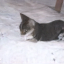

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms 

from diffusers import ConsistencyModelPipeline

device = "cuda"
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

CLASS = [281]

preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83
image = pipe(num_inference_steps=40, class_labels=CLASS).images[0]
image

In [2]:
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01, 9.1628e-02, 6.2762e-02, 4.2071e-02, 2.7525e-02, 1.7522e-02,
        1.0812e-02, 6.4371e-03, 3.6766e-03, 2.0000e-03, 2.0000e-03])

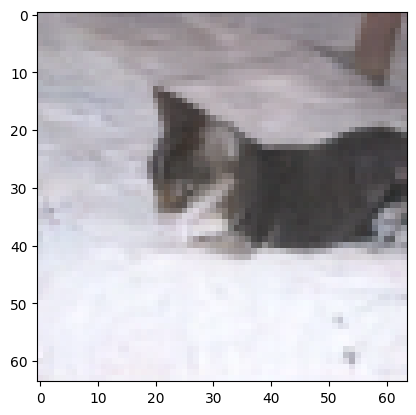

In [3]:
plt.imshow(
    np.moveaxis(np.array(transforms.ToTensor()(image)), 0, -1)
)
img_orig = transforms.ToTensor()(image)

## Denoising function

In [4]:
def denoise(sample, sigma):
    
    t = pipe.scheduler.sigma_to_t(sigma)
    
    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)
    
    scaled_sample = sample / ((sigma**2 + 1) ** 0.5)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor(CLASS, device=device),
        return_dict=False
    )[0]

    
    return c_out * model_output + c_skip * sample

def model(sample, sigma):
    
    t = pipe.scheduler.sigma_to_t(sigma)
    
    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)
    
    scaled_sample = sample / ((sigma**2 + 1) ** 0.5)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor(CLASS, device=device),
        return_dict=False
    )[0]

    
    return model_output

## Denoise output

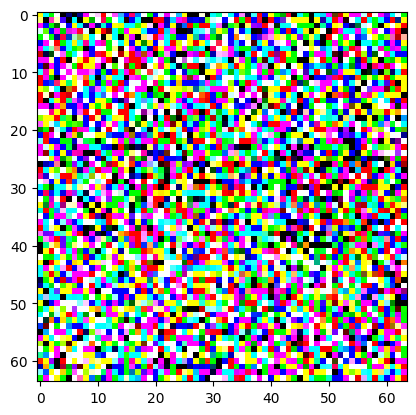

In [5]:
sigma = 5

img = preprocess(image)[None, :].to(device).type(torch.float16)

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

plt.imshow(
    pipe.postprocess_image((img + z).type(torch.float32), "np")[0]
)

In [6]:
img_n = img + z

/tmp/ipykernel_5341/3109570201.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)


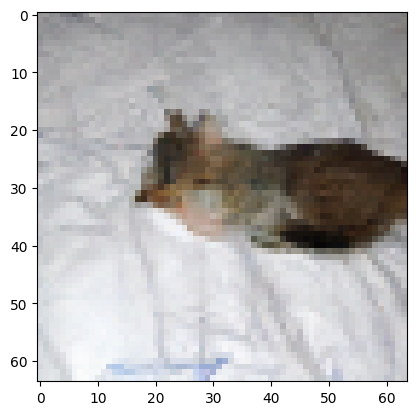

In [7]:
img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)

plt.imshow(
    pipe.postprocess_image(img_dn.cpu(), "np")[0]
)

## One Hot Tests

In [8]:
def one_hot(i, dtype=torch.float16, num_classes=12288, reshape=True, device="cuda"):
    if isinstance(i, int):
        i = torch.tensor([i])

    oh = torch.nn.functional.one_hot(i, num_classes=num_classes).to(device).to(dtype)

    if reshape:
        oh = torch.reshape(oh[0], (1, 3, 64, 64))
        
    return oh

def denoise_and_plot(img, sigma, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    img_dn = denoise(img, sigma)
    img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)
    ax.imshow(
        pipe.postprocess_image(img_dn.cpu(), "np")[0]
    )
    return ax

def model_and_plot(img, sigma):
    fig, ax = plt.subplots(1,1)
    img_dn = model(img, sigma)
    img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)
    ax.imshow(
        pipe.postprocess_image(img_dn.cpu(), "np")[0]
    )

i = 2070 # + 2 * 64 * 64
sigma = 3

#img = one_hot(i) * torch.exp(torch.tensor([sigma], dtype=torch.float16)).to(device)

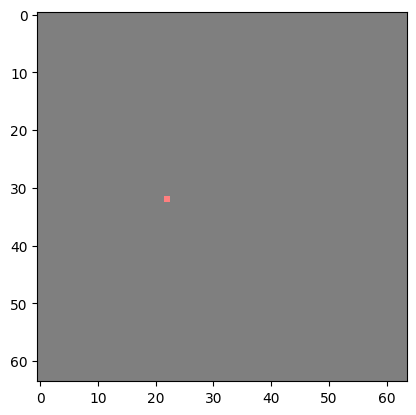

In [9]:
plt.imshow(
    pipe.postprocess_image(one_hot(i, dtype = torch.float32, device="cpu"), "np")[0]
)

/tmp/ipykernel_5341/1399217821.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pipe.postprocess_image(torch.tensor(img_n, dtype=torch.float32).detach().cpu(), "np")[0]
/tmp/ipykernel_5341/2641483140.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)


<Axes: >

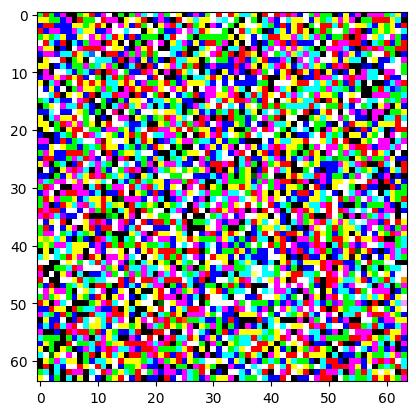

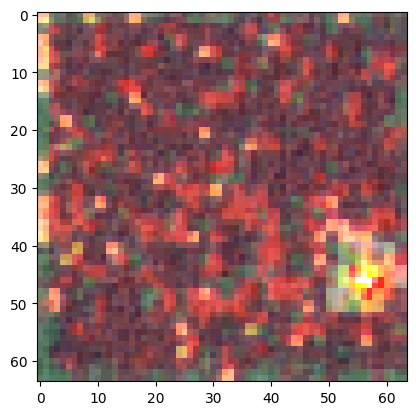

In [12]:
i = 3000 # + 2 * 64 * 64
sigma = 80
scale = torch.sqrt(torch.tensor(12288)) * 5 * sigma

img = one_hot(i) * scale 

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

img_n = img + z

#img_n = z

plt.imshow(
    pipe.postprocess_image(torch.tensor(img_n, dtype=torch.float32).detach().cpu(), "np")[0]
)

denoise_and_plot(img_n, sigma=sigma)

/tmp/ipykernel_2931/2641483140.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)


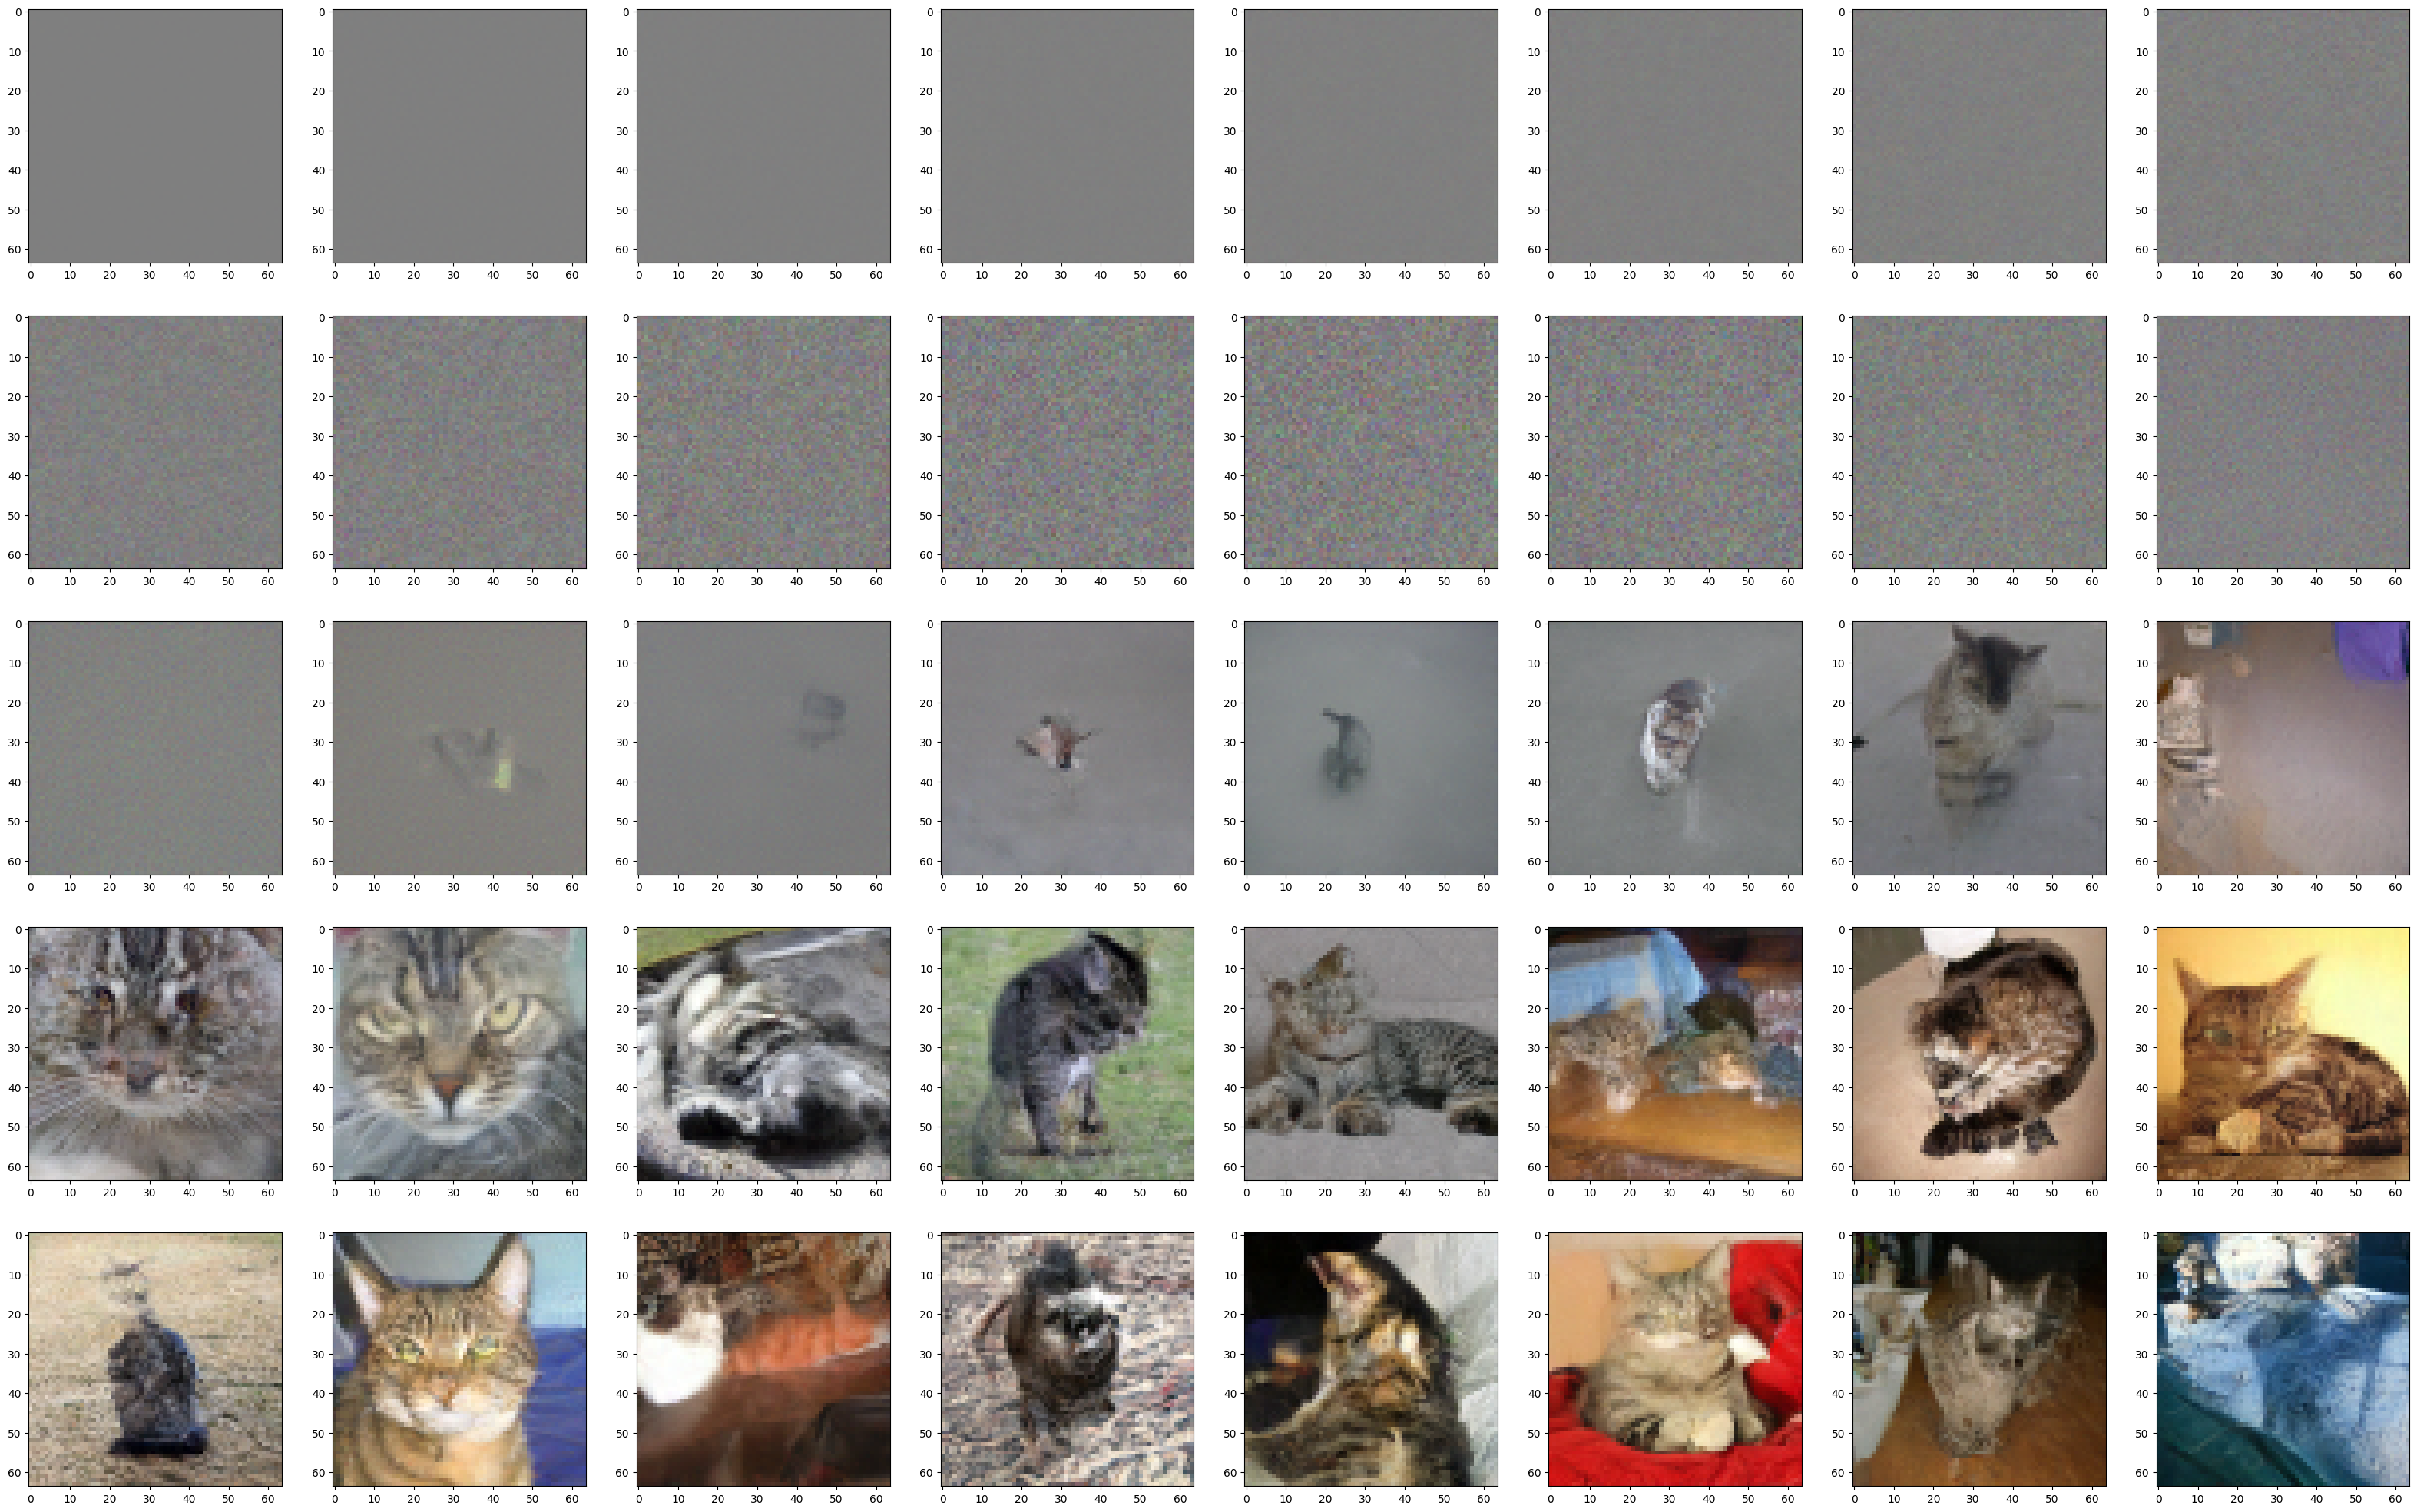

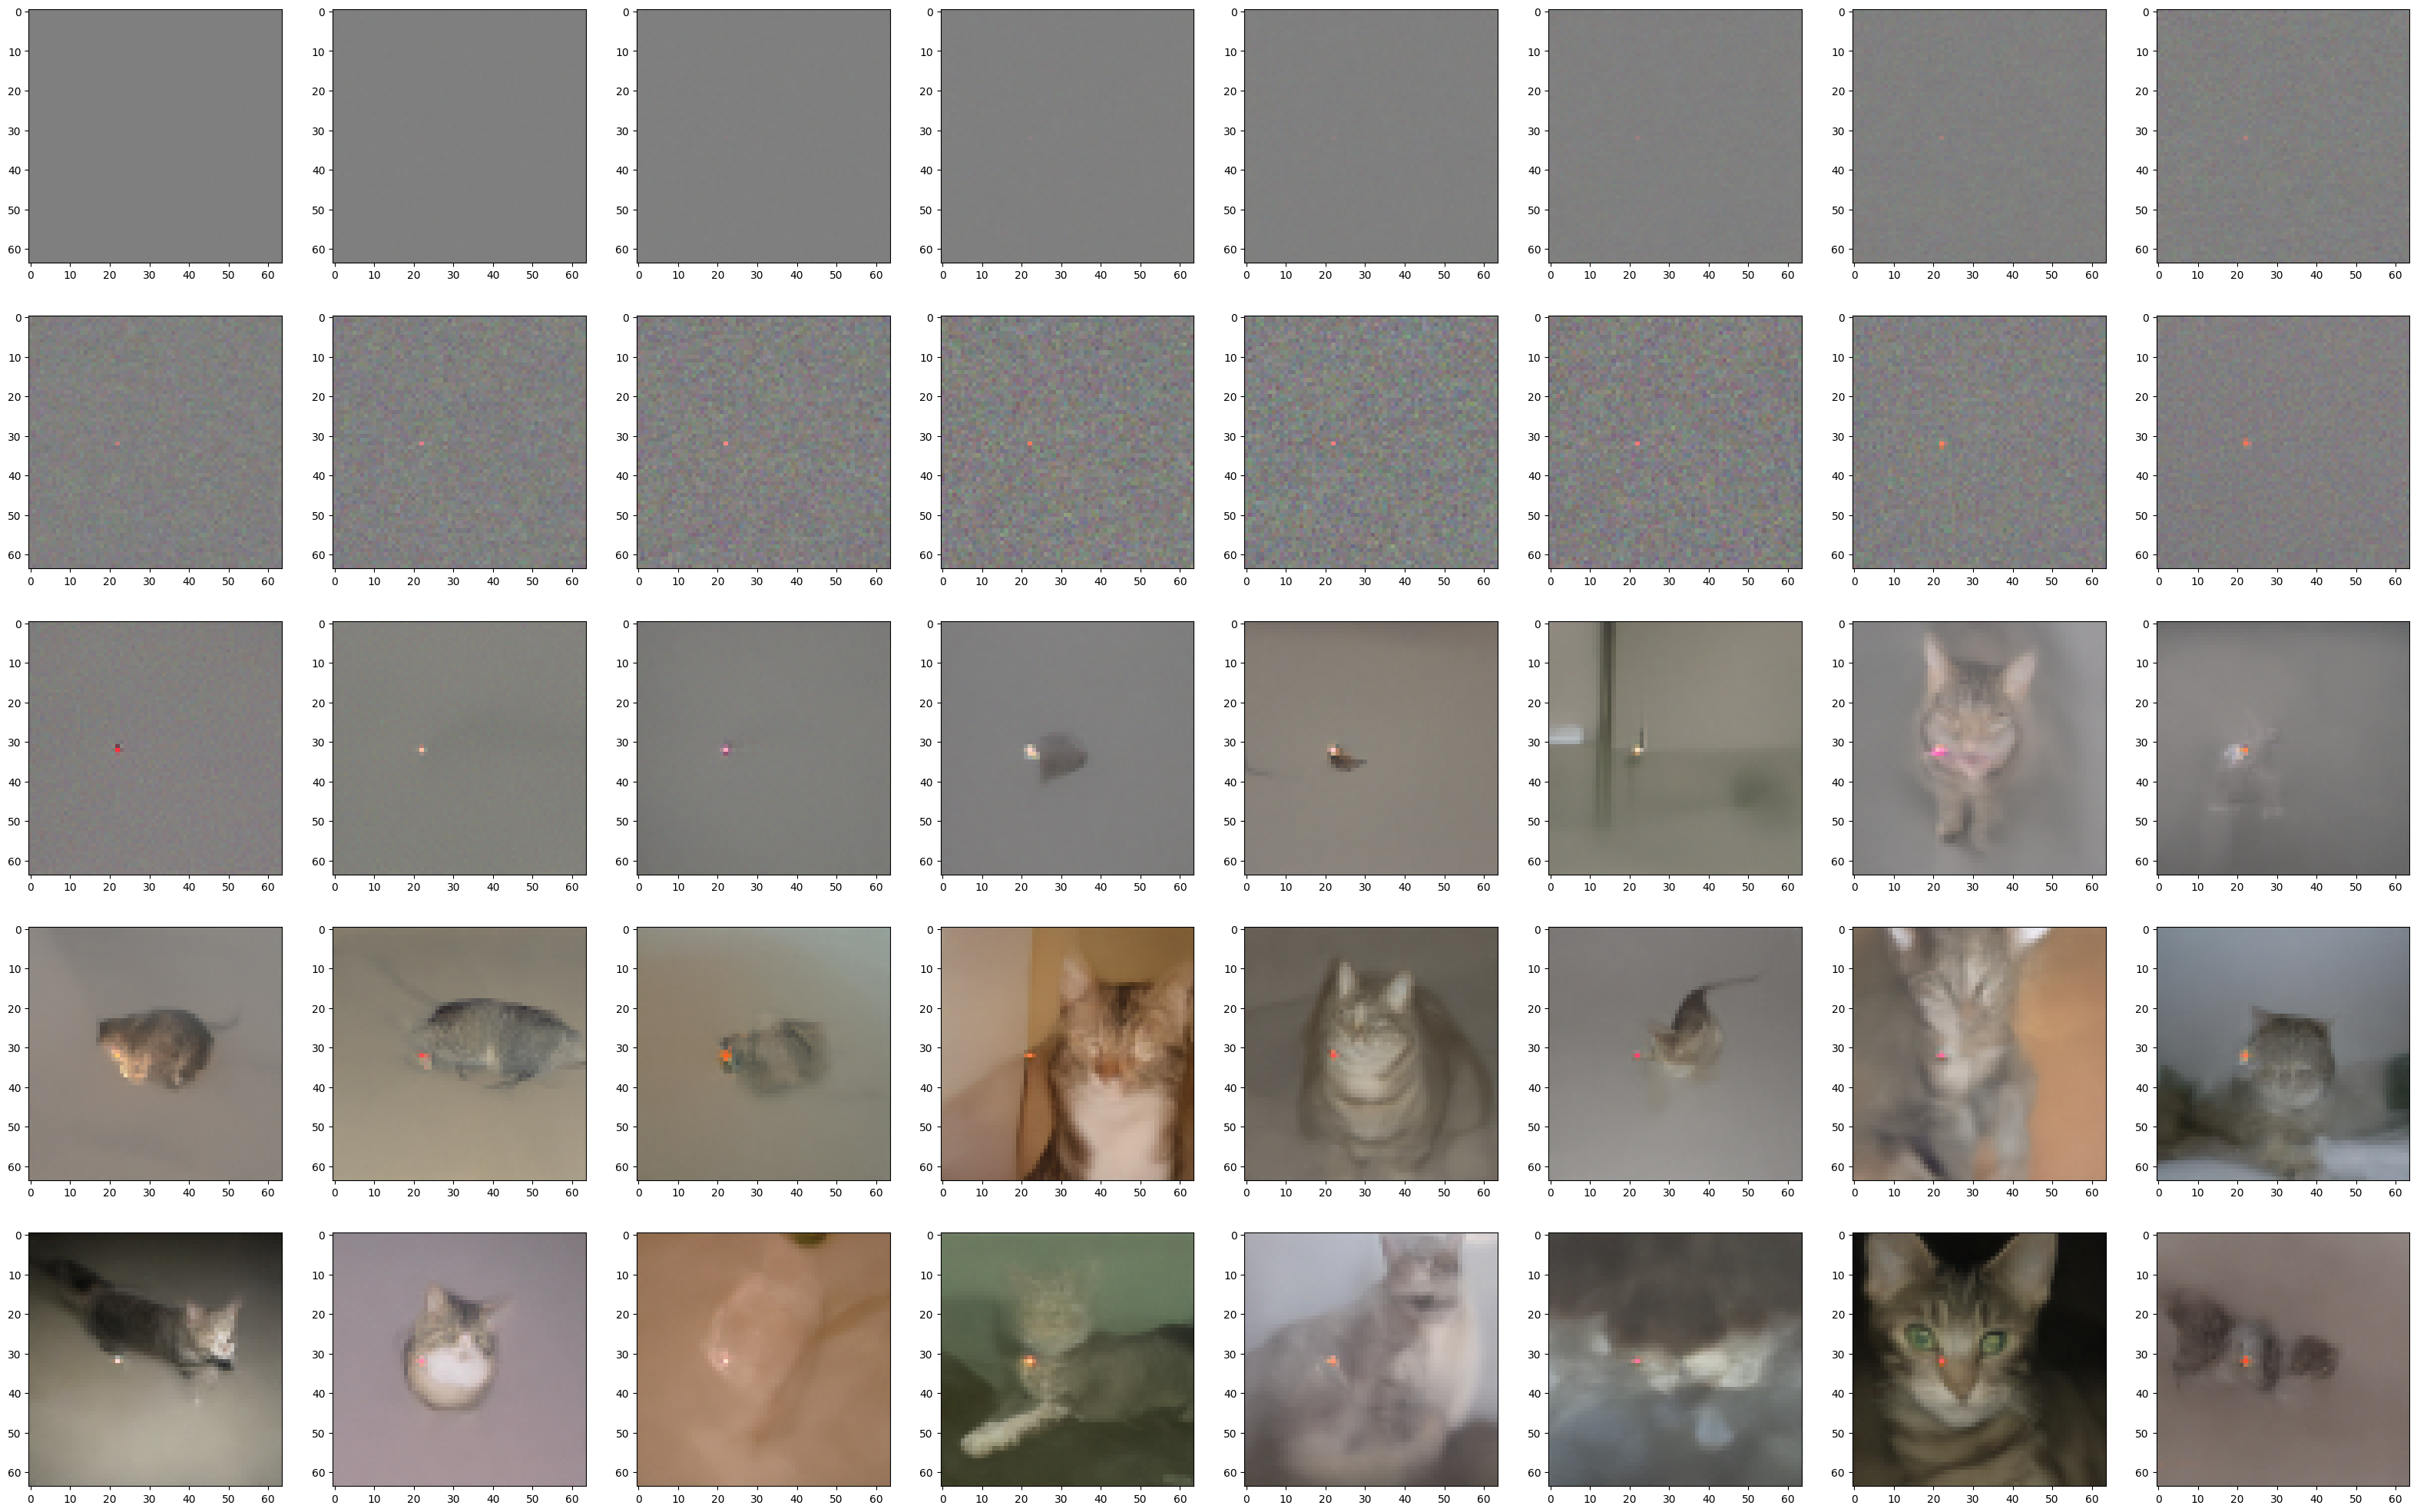

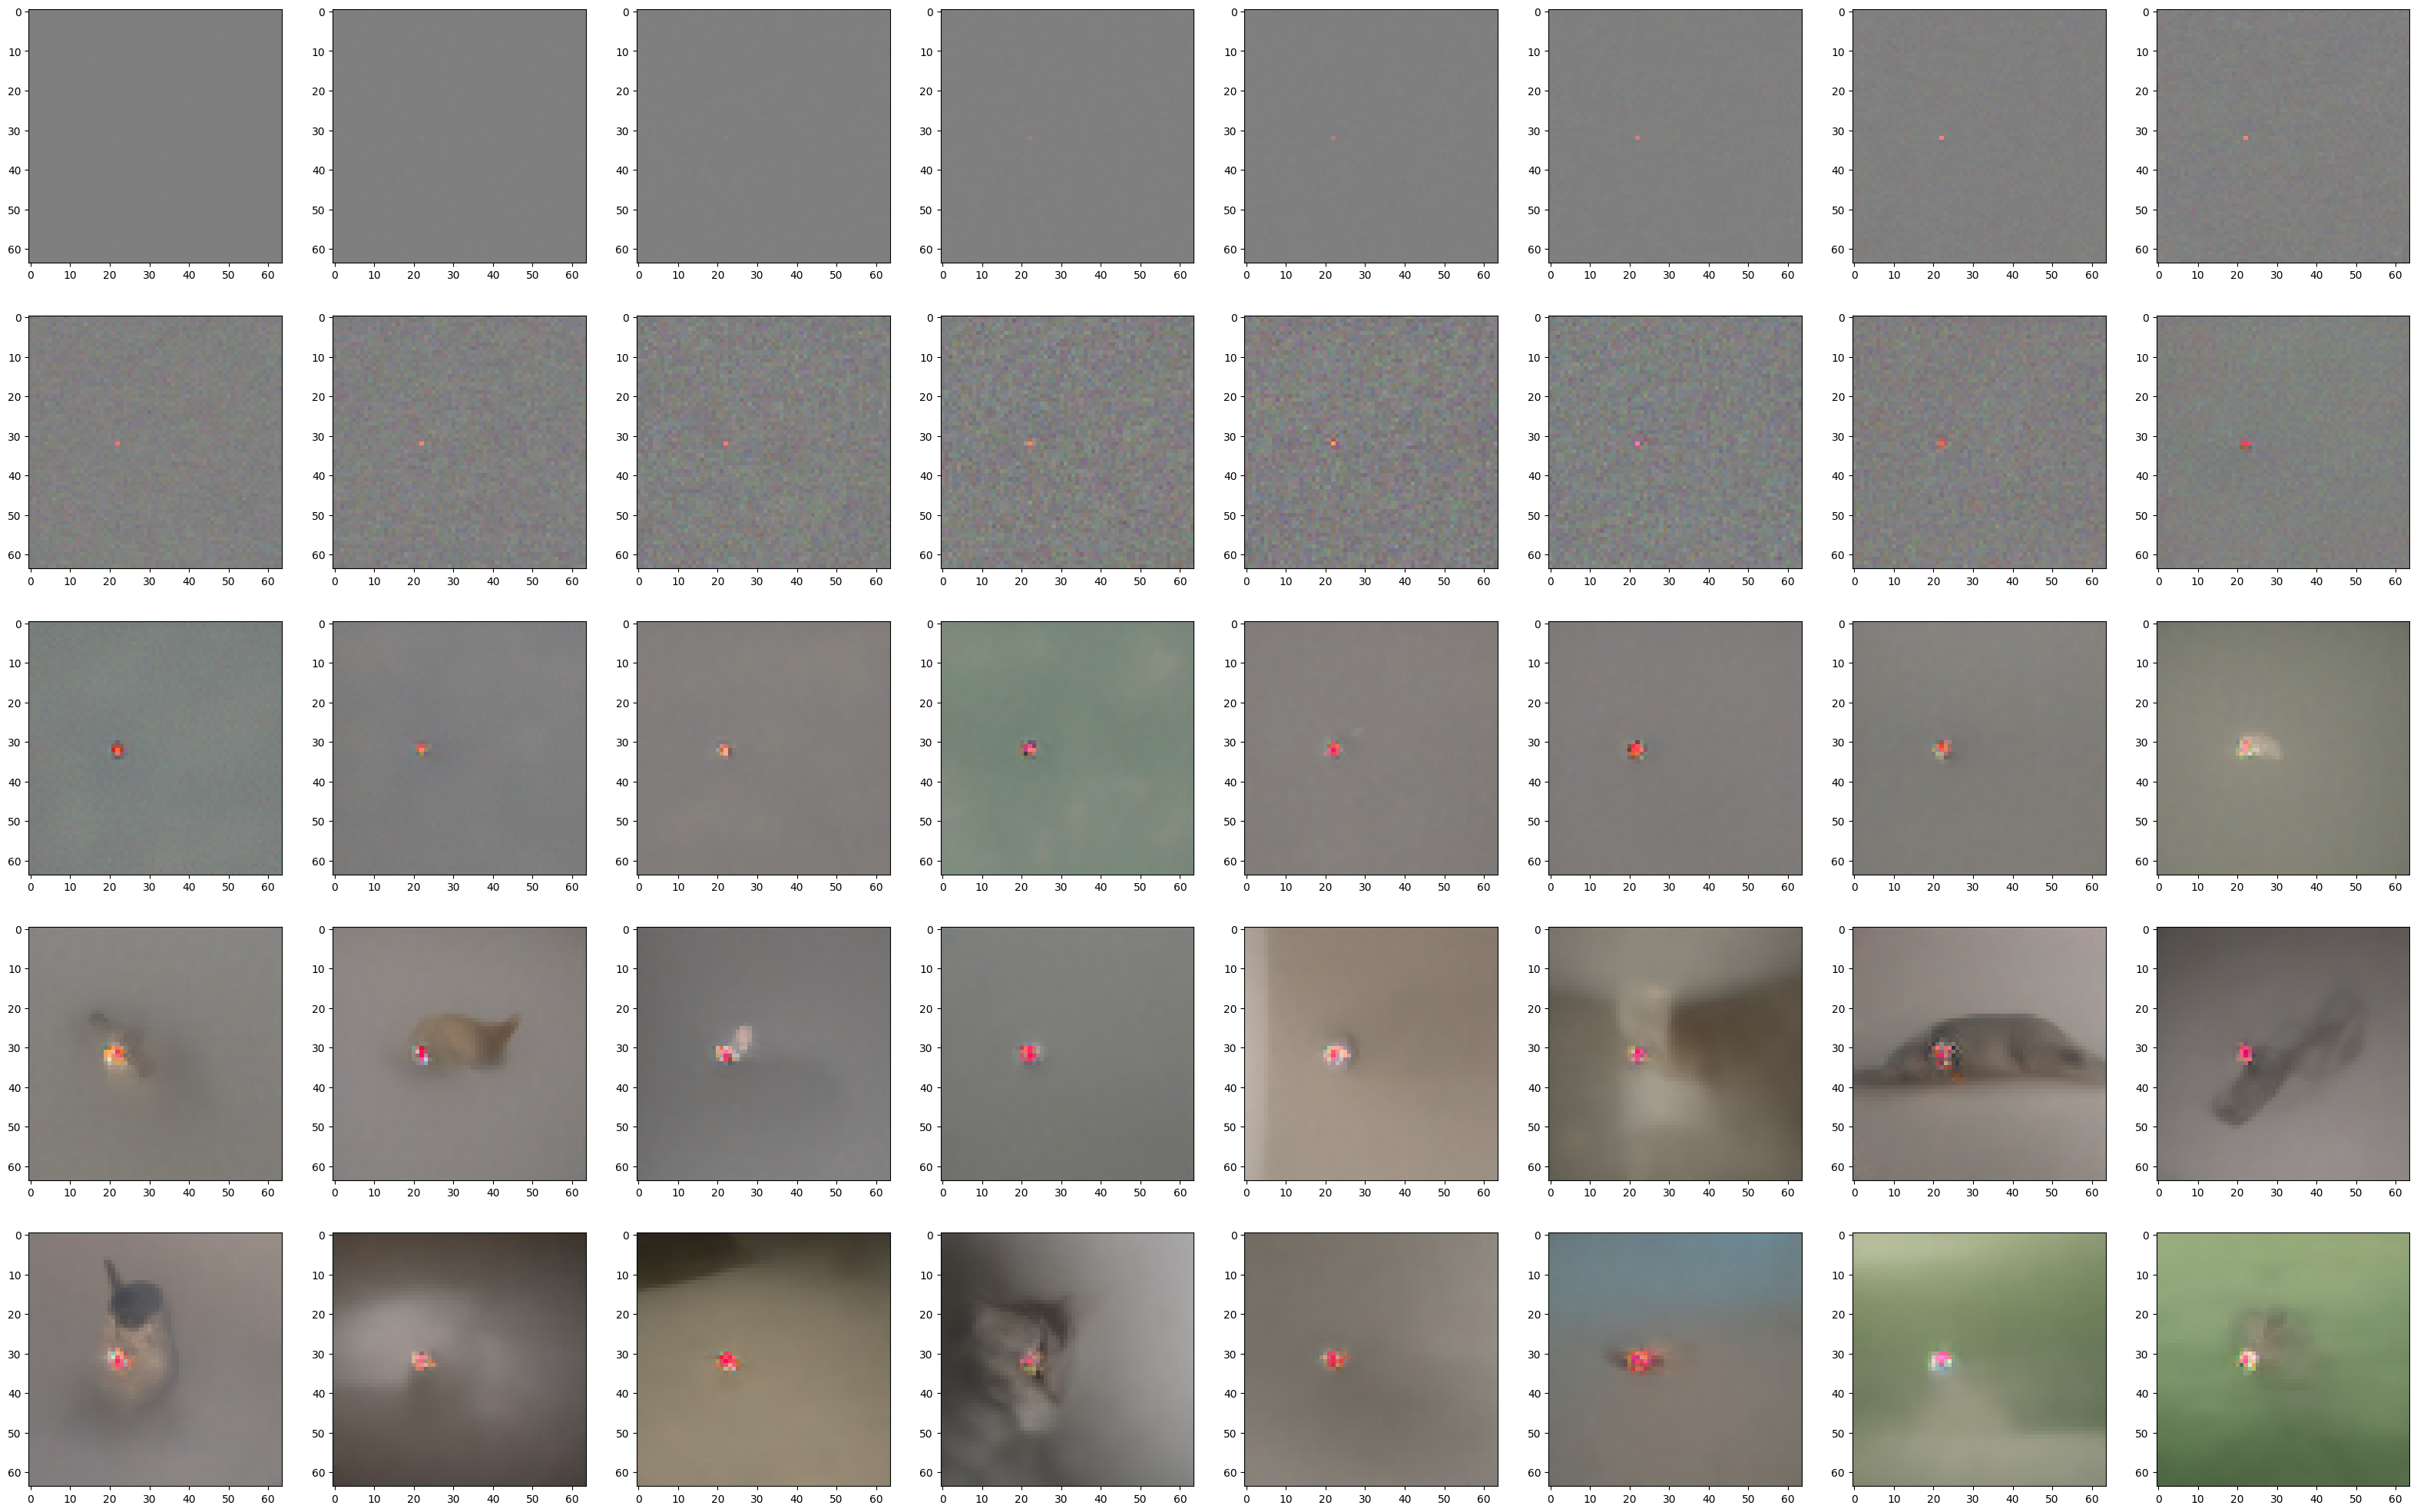

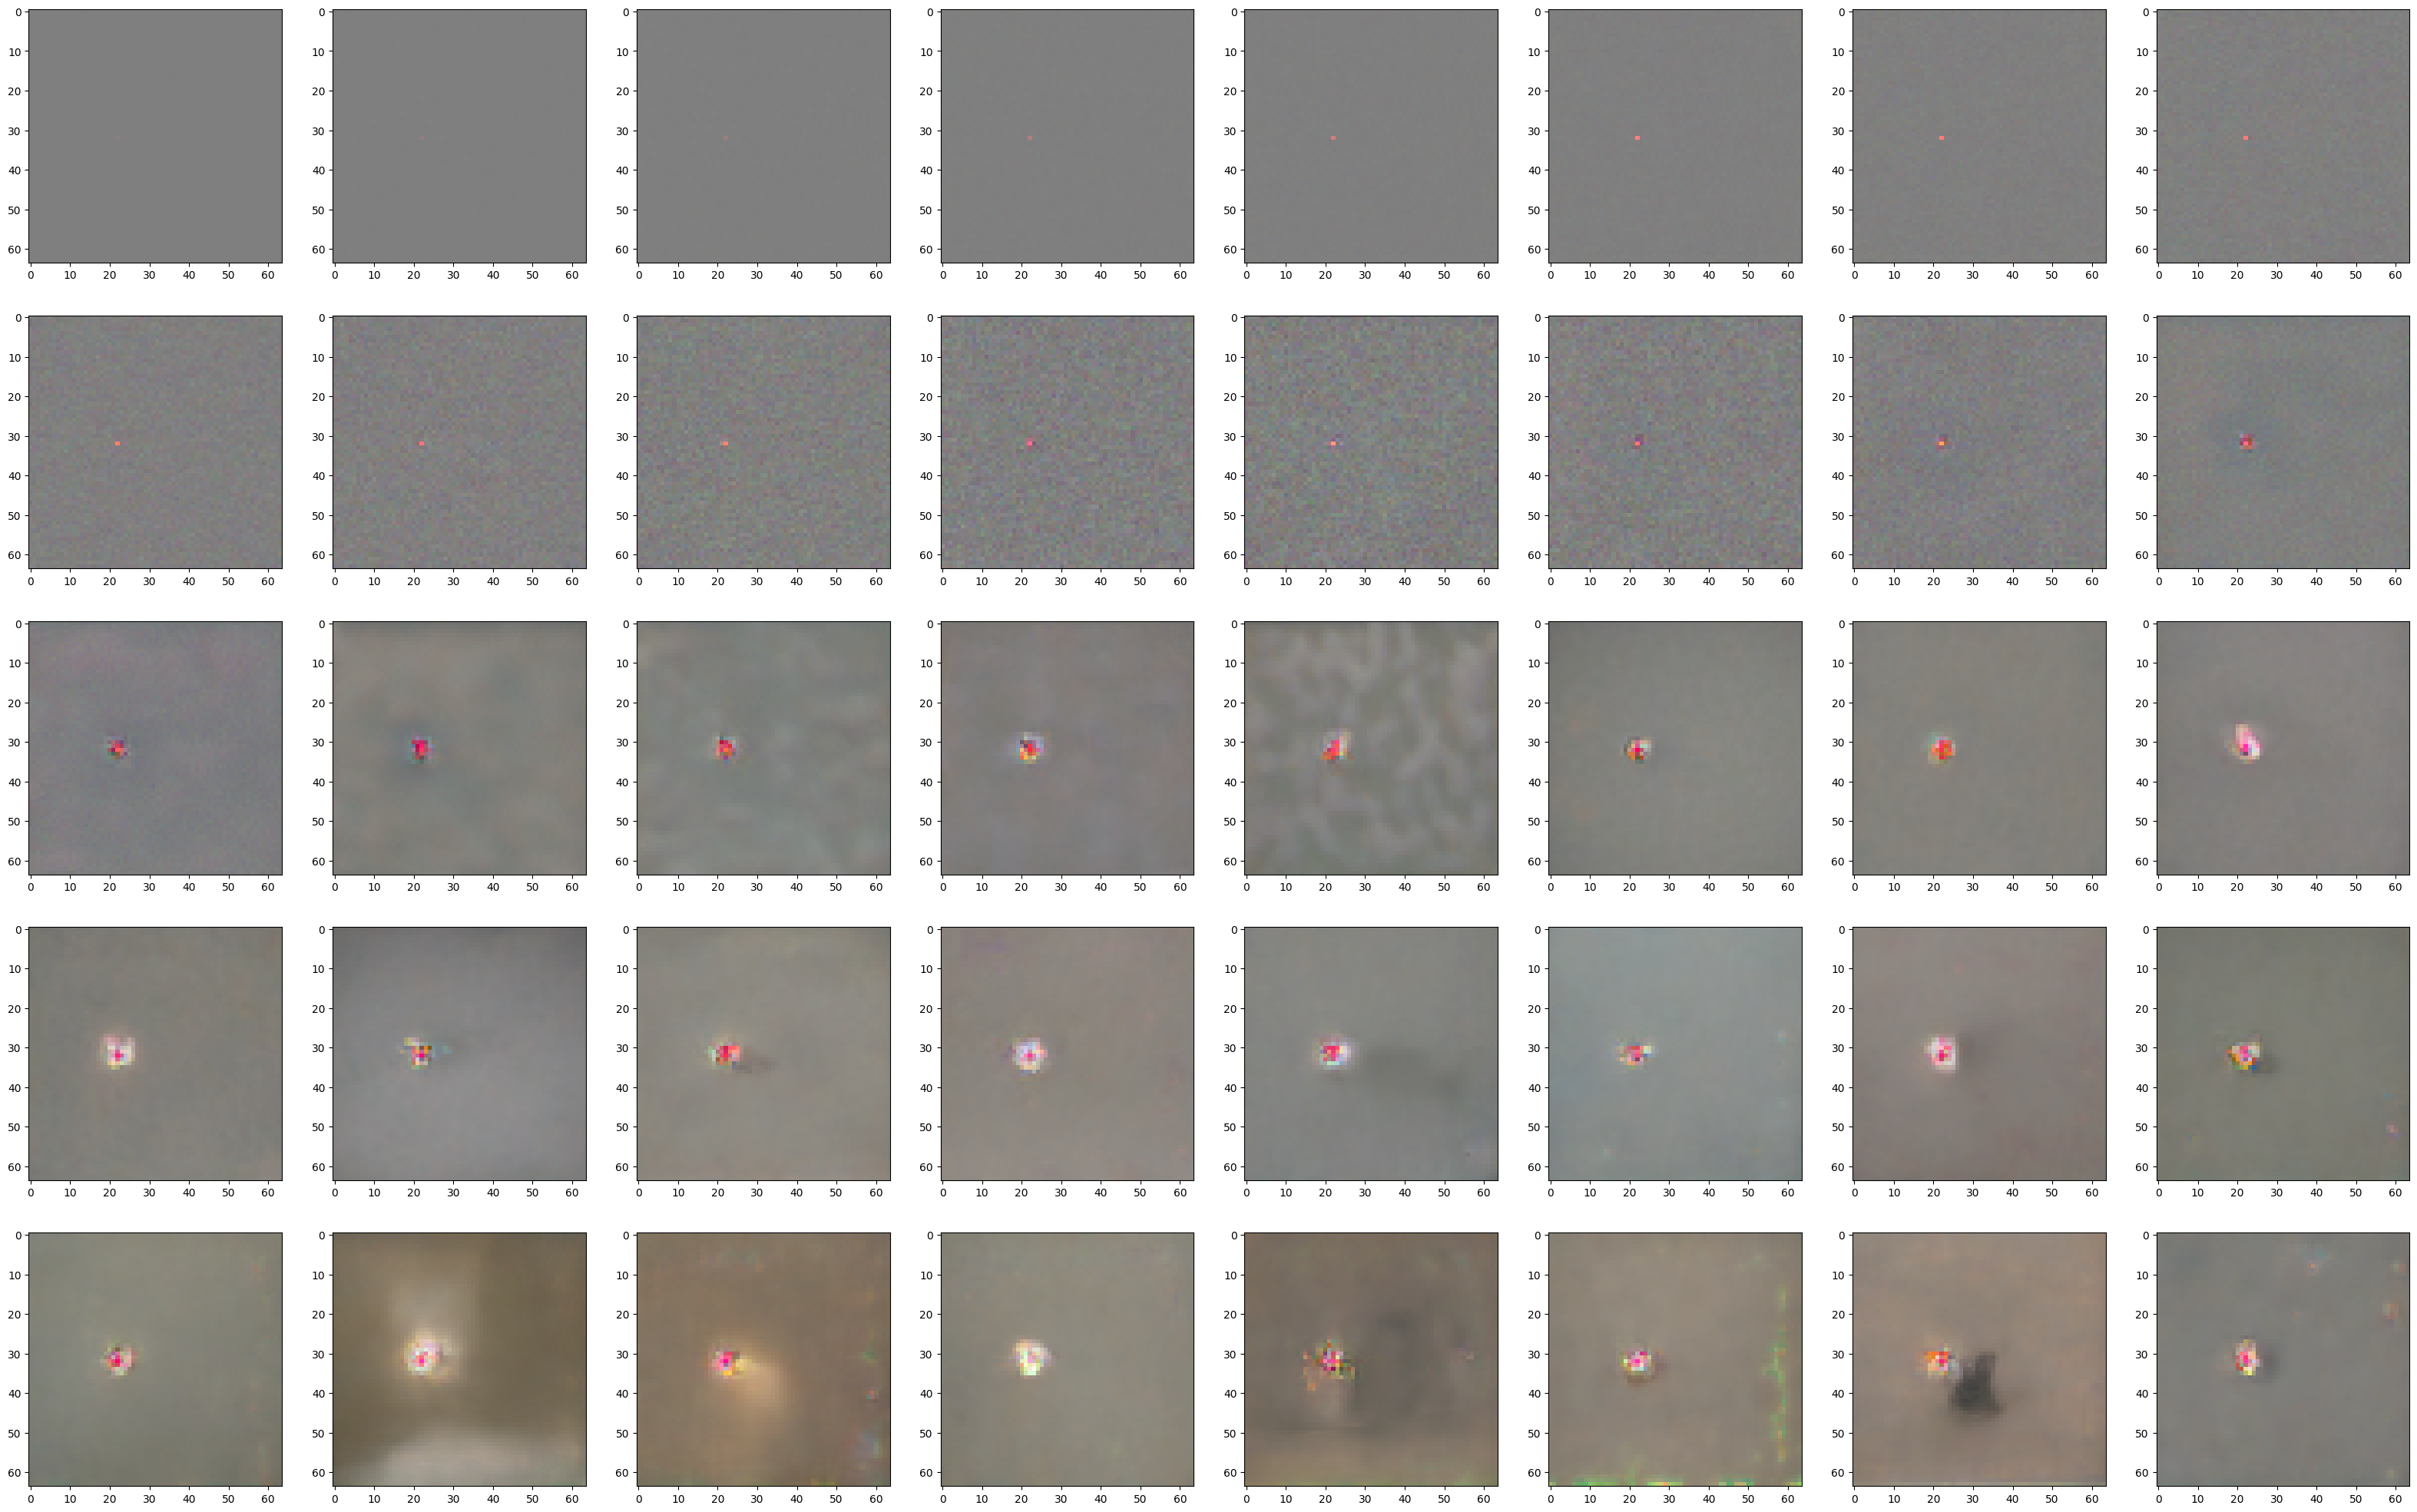

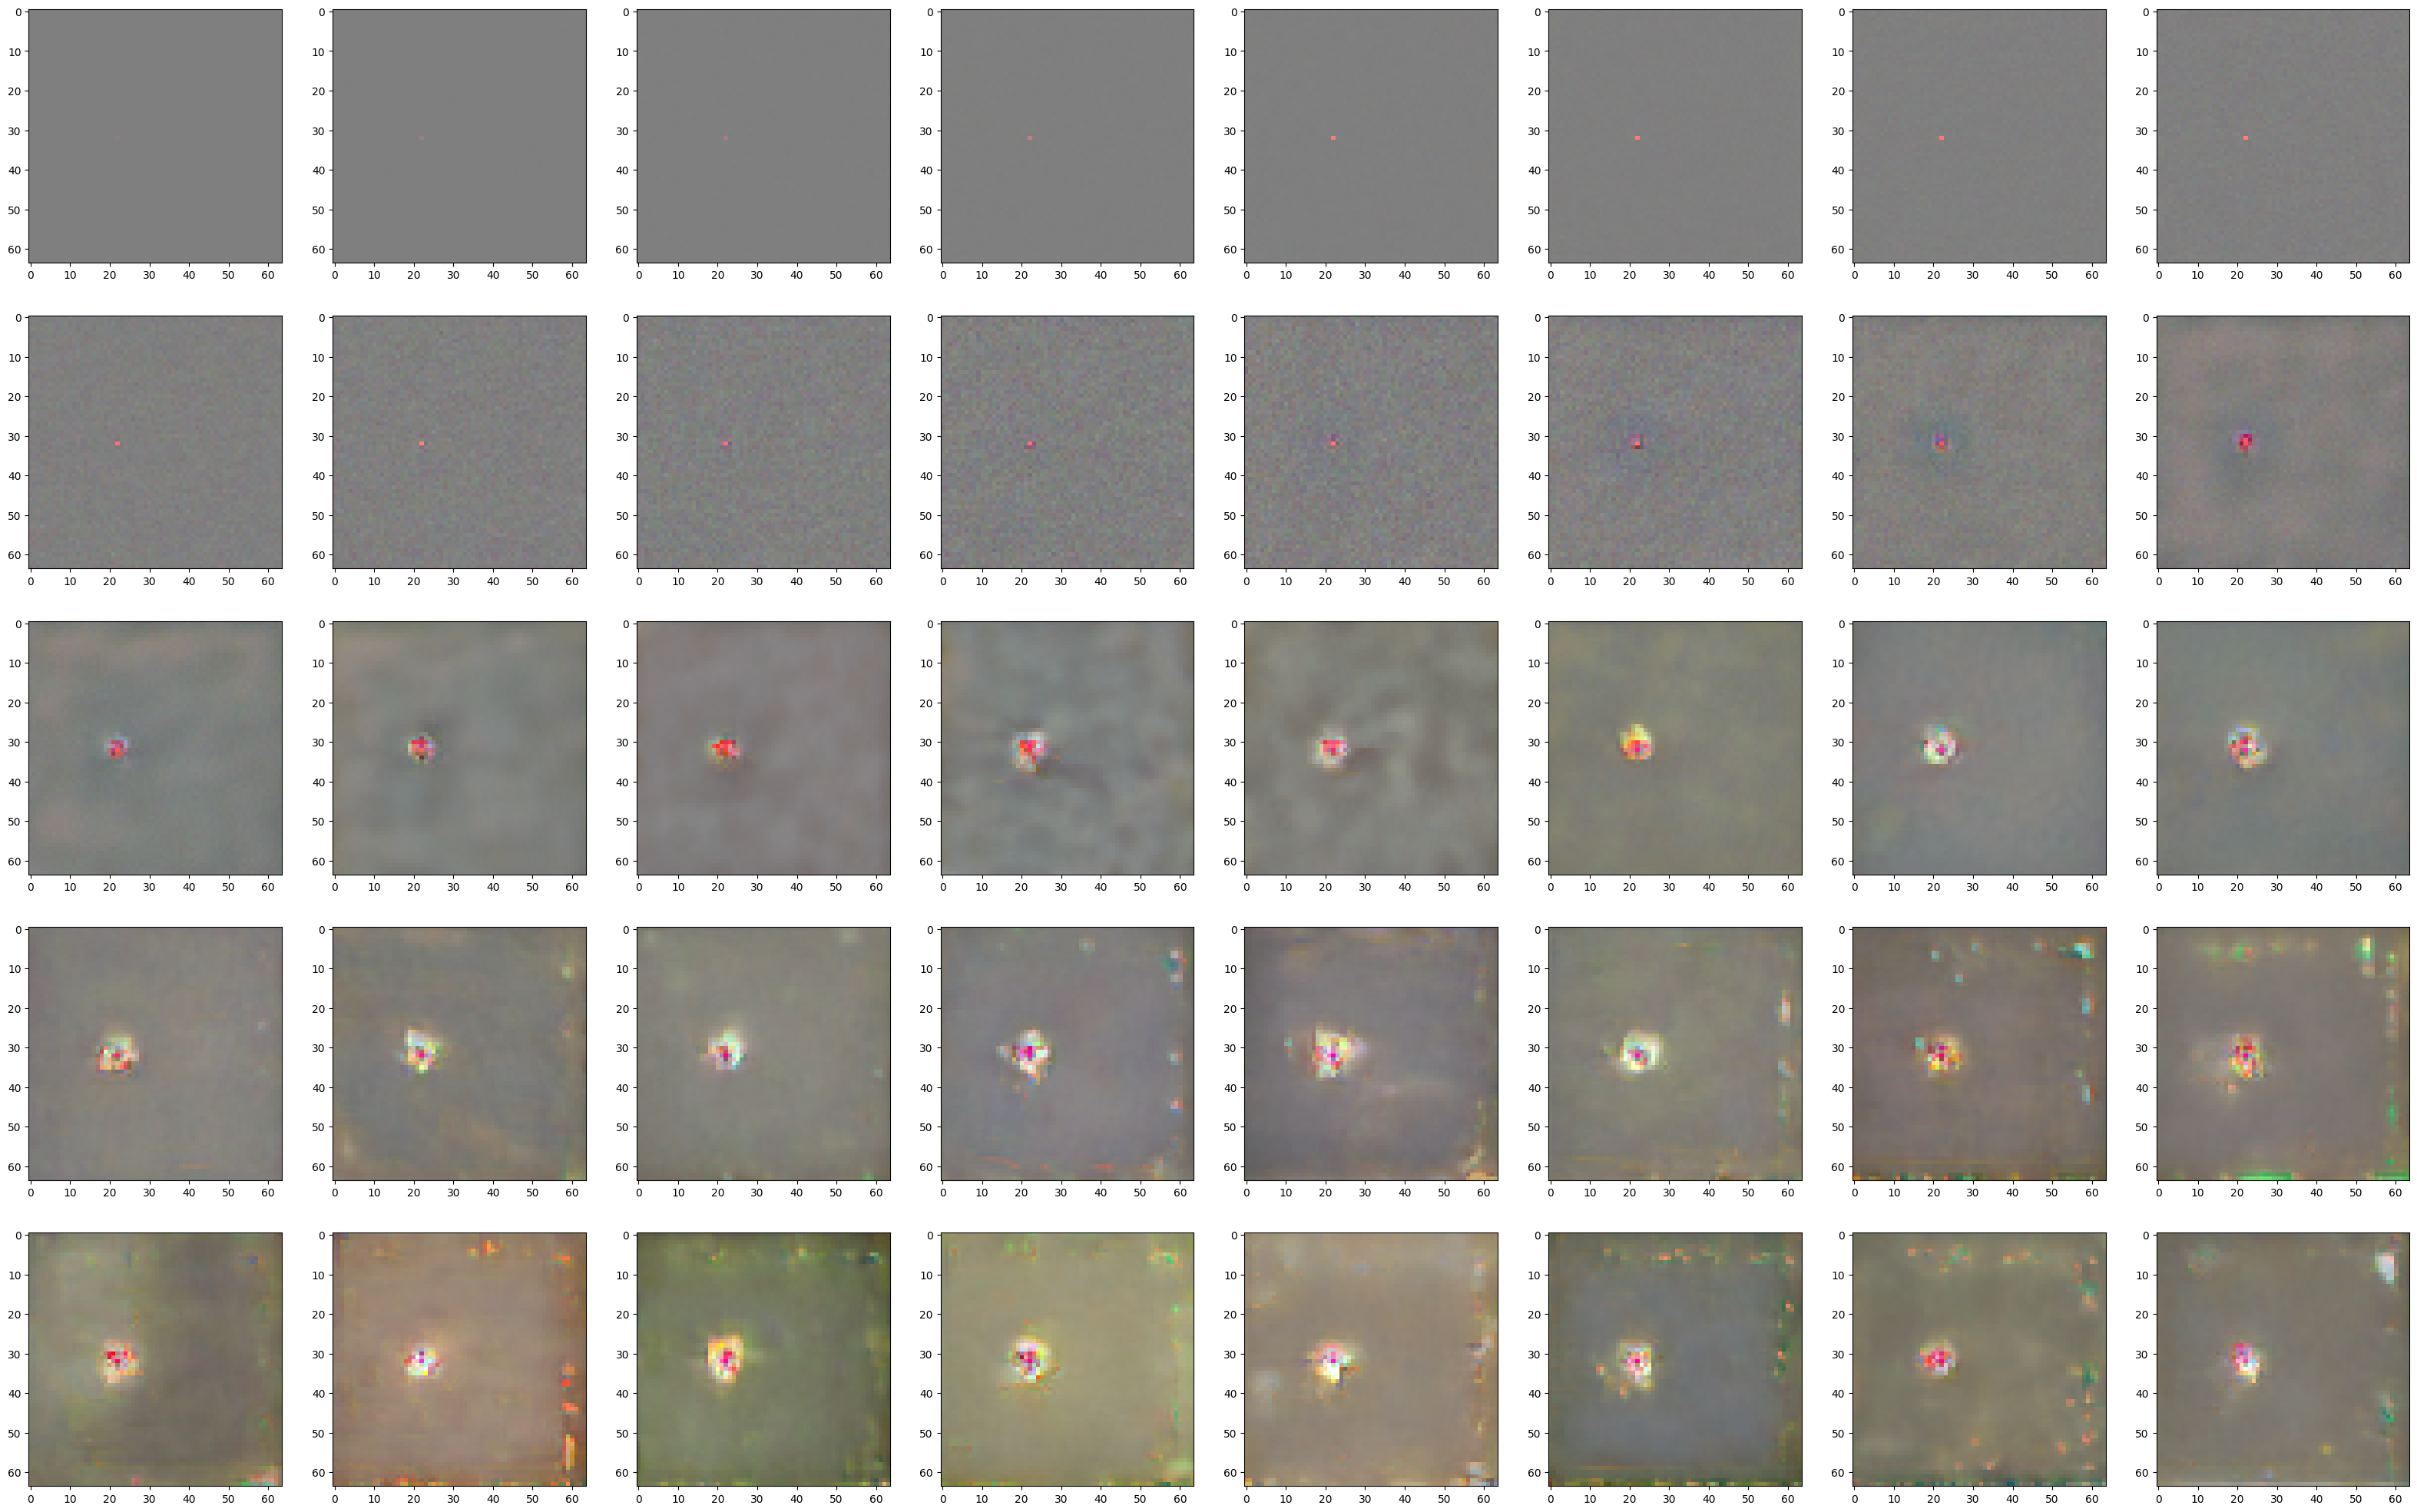

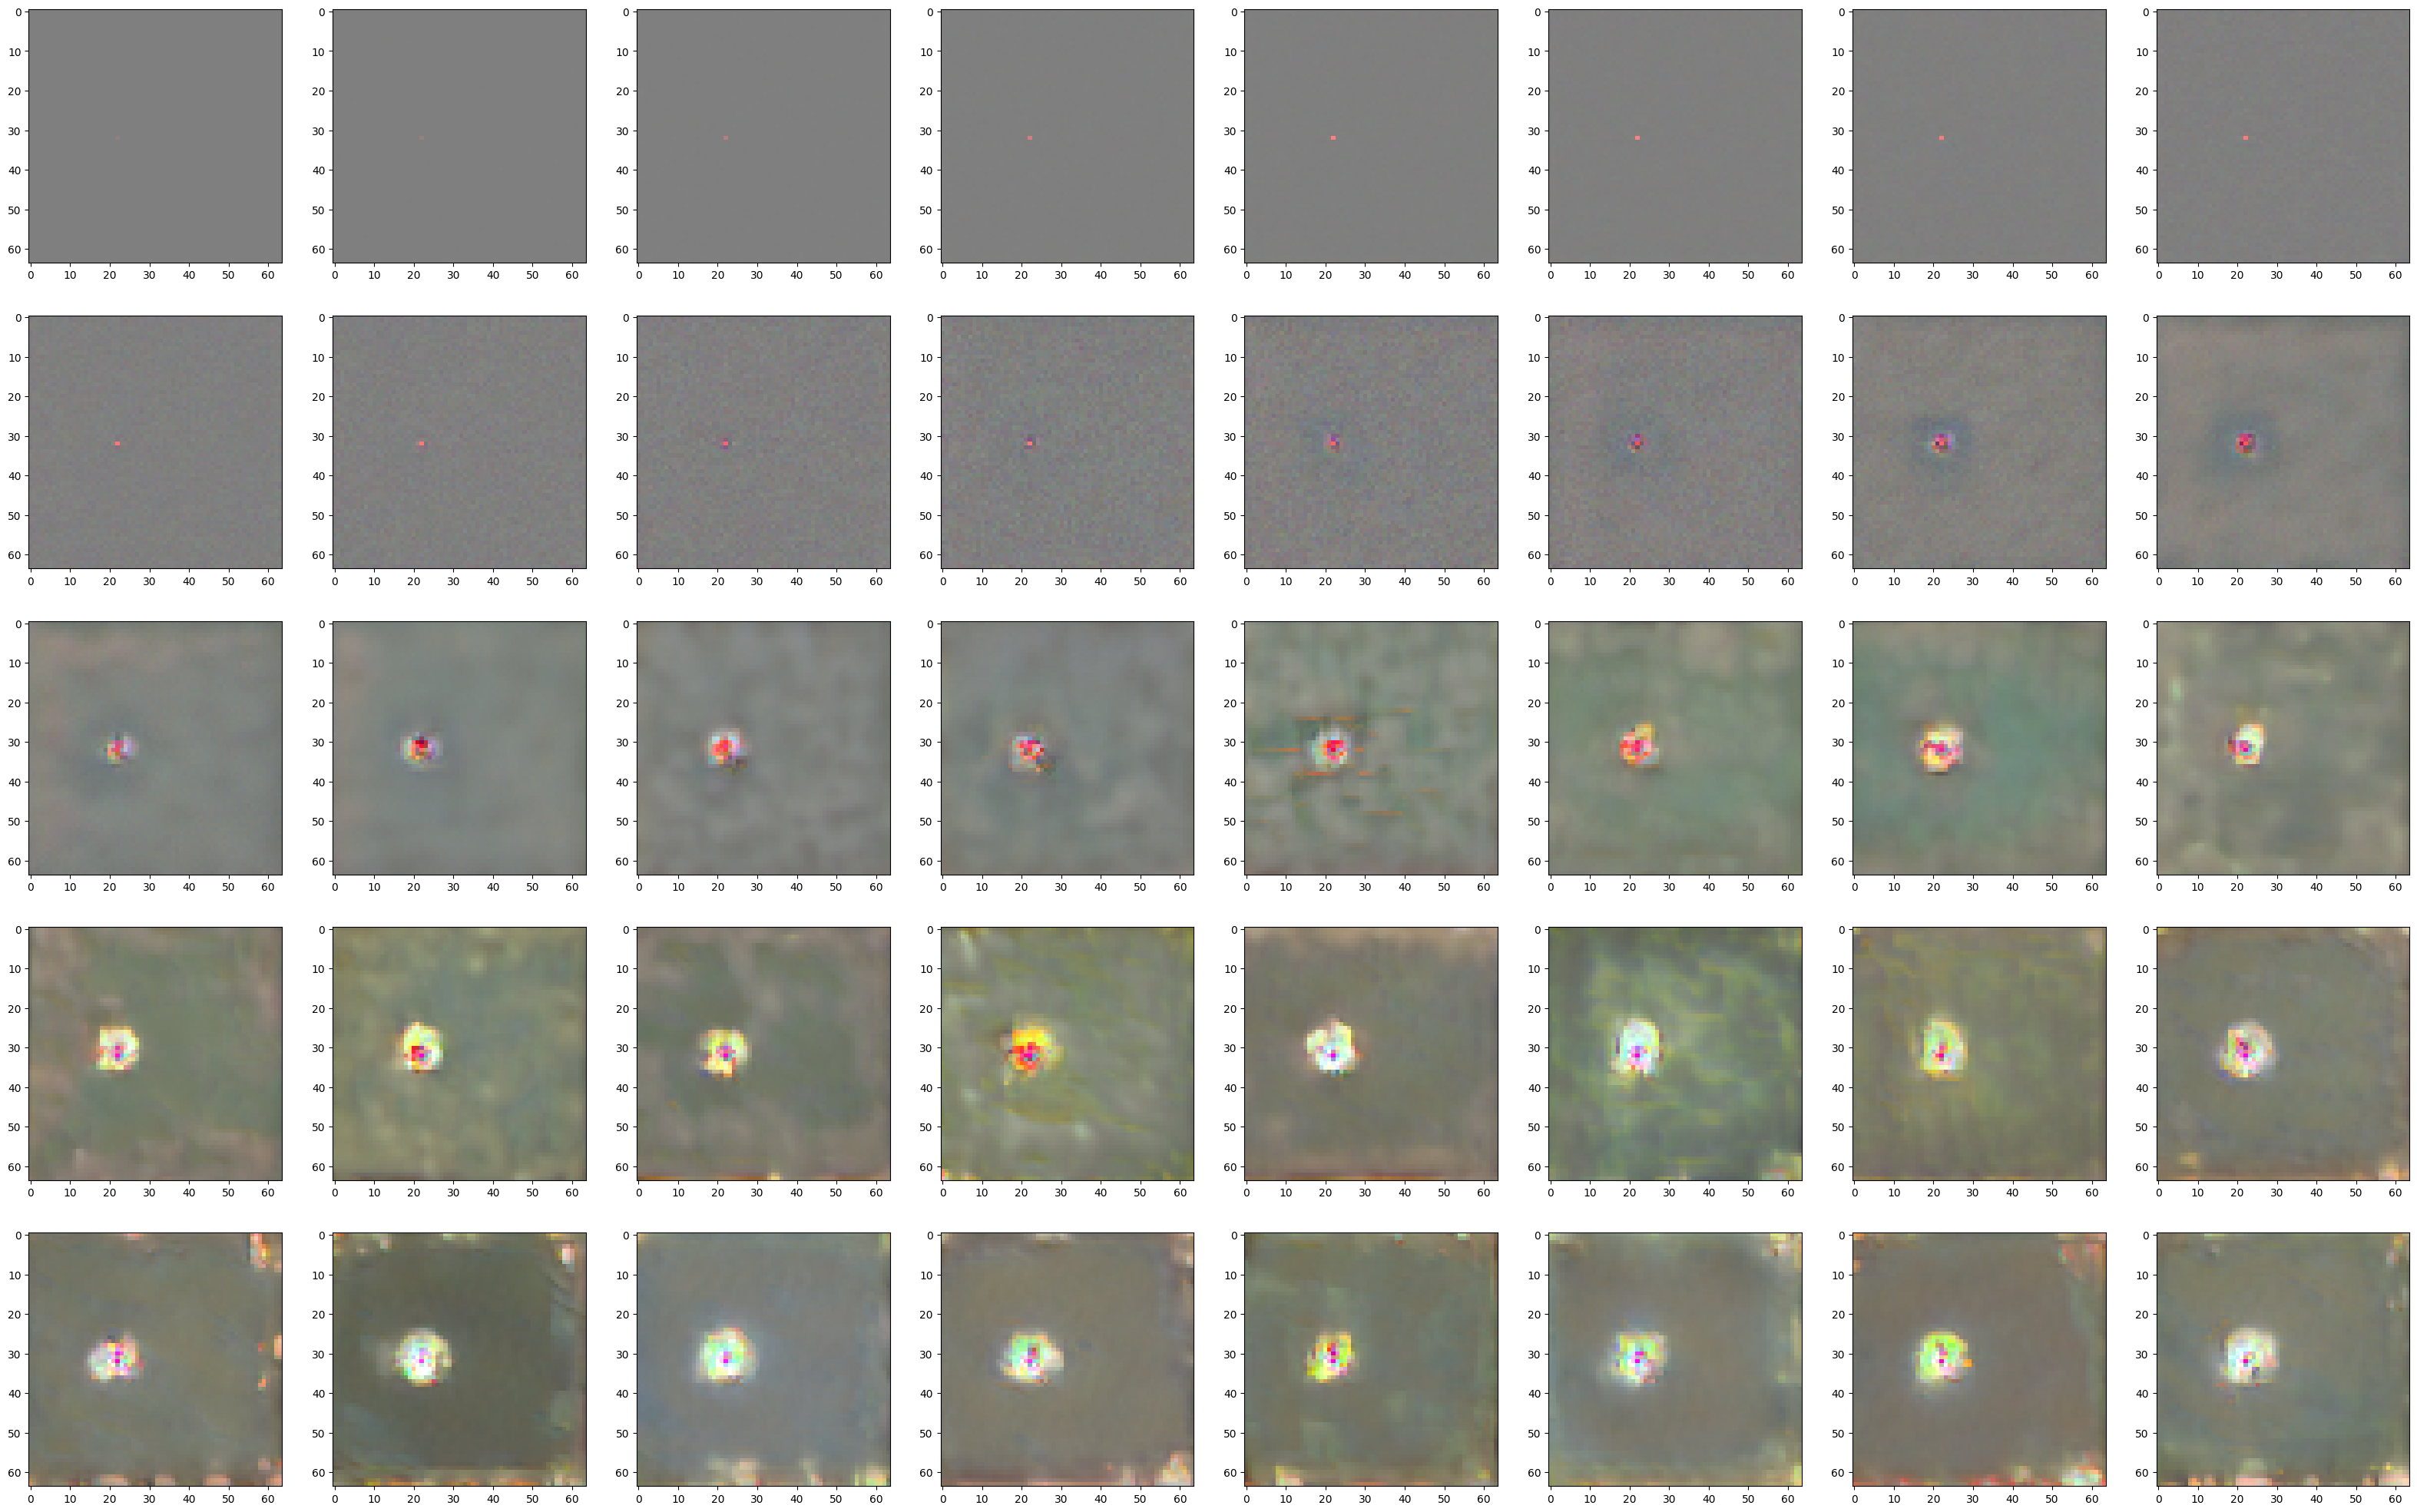

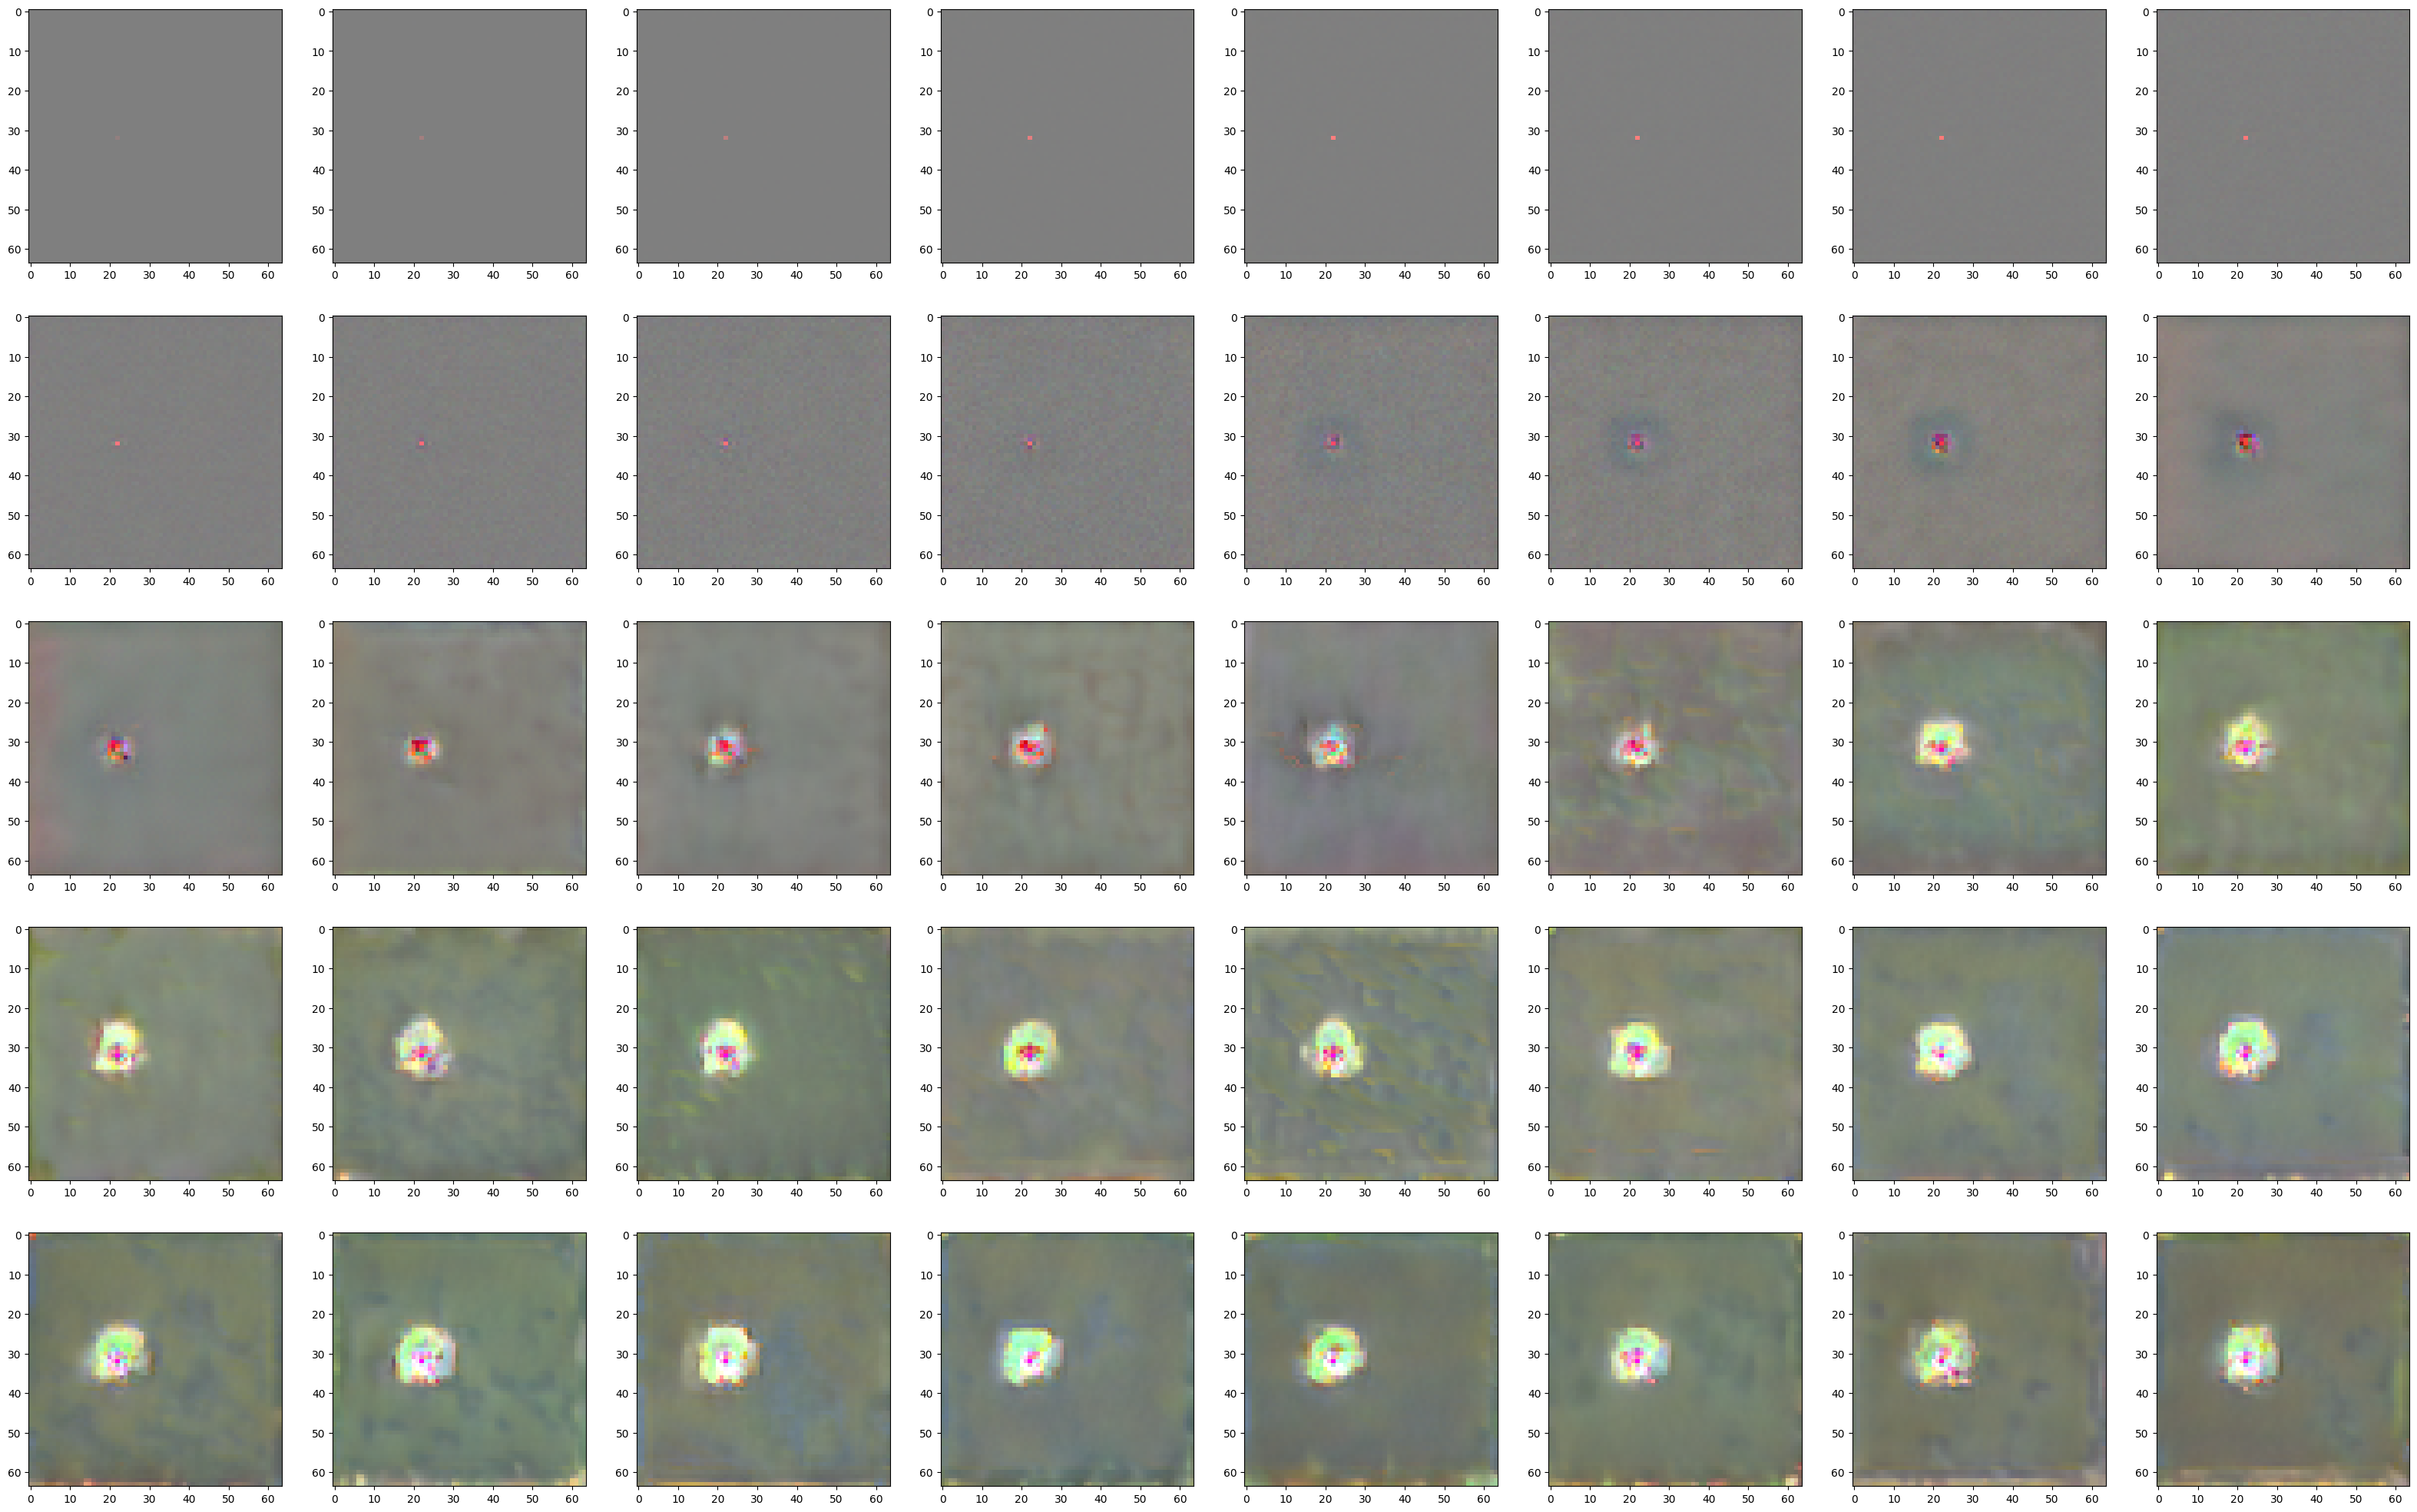

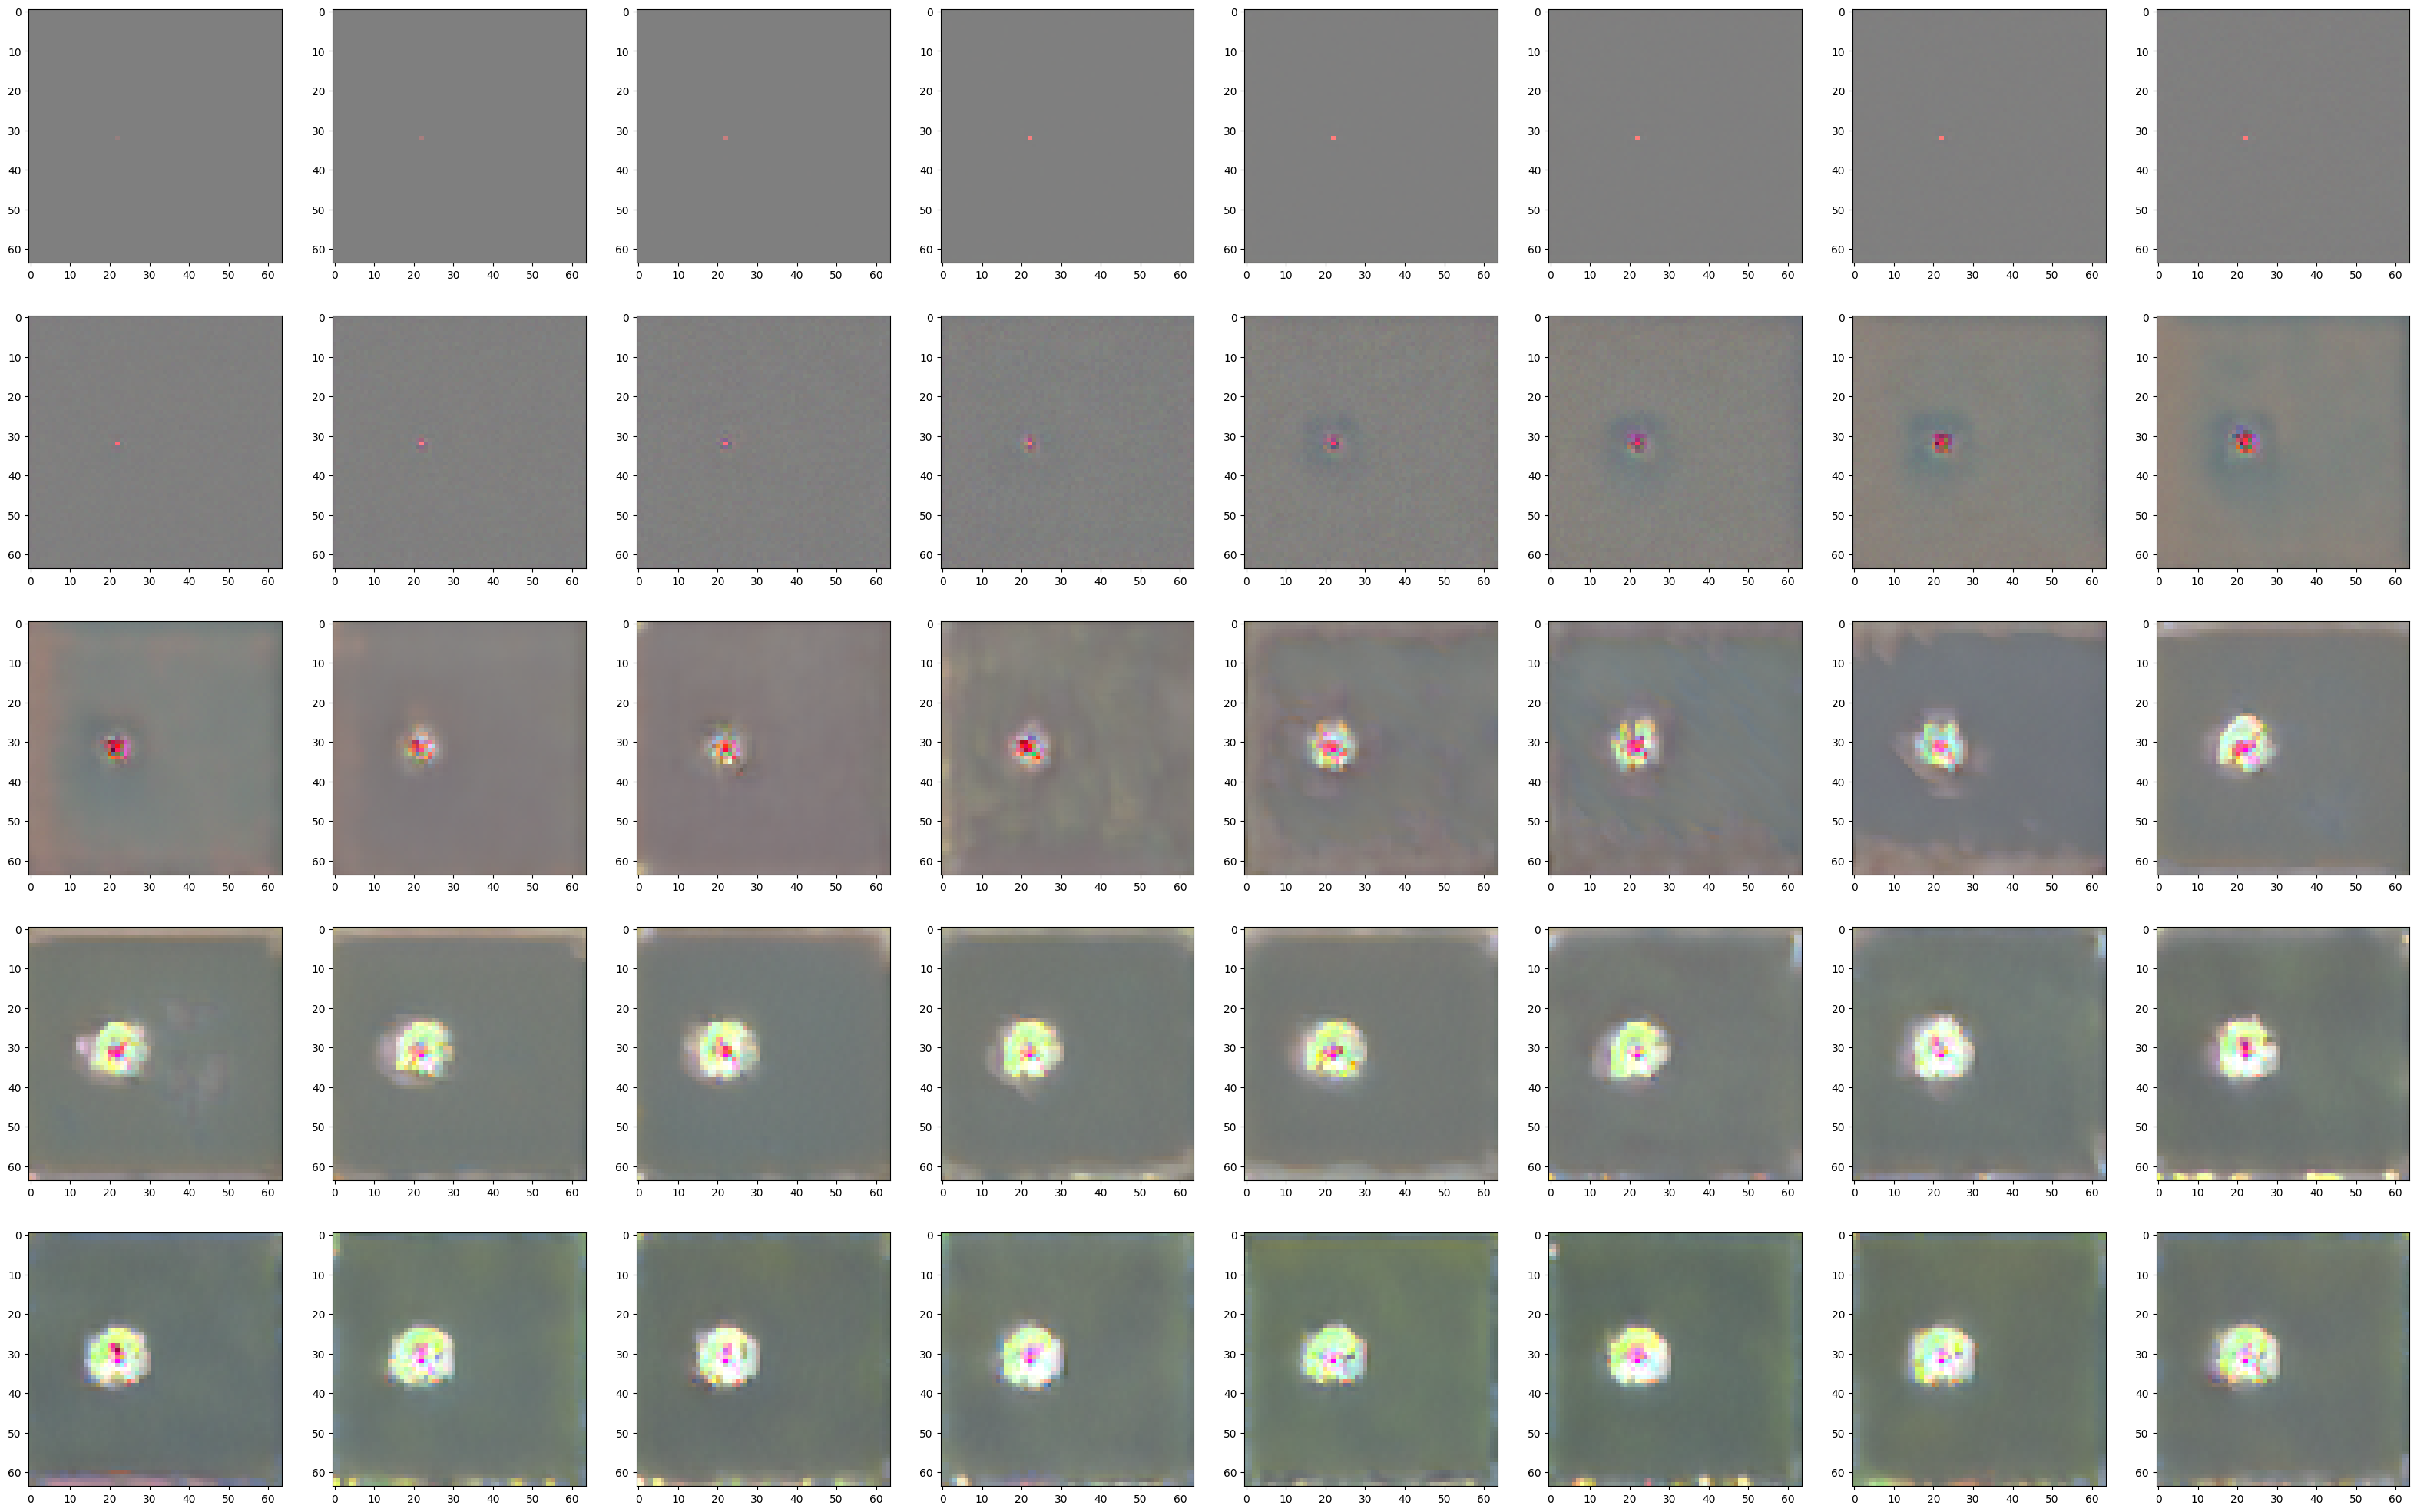

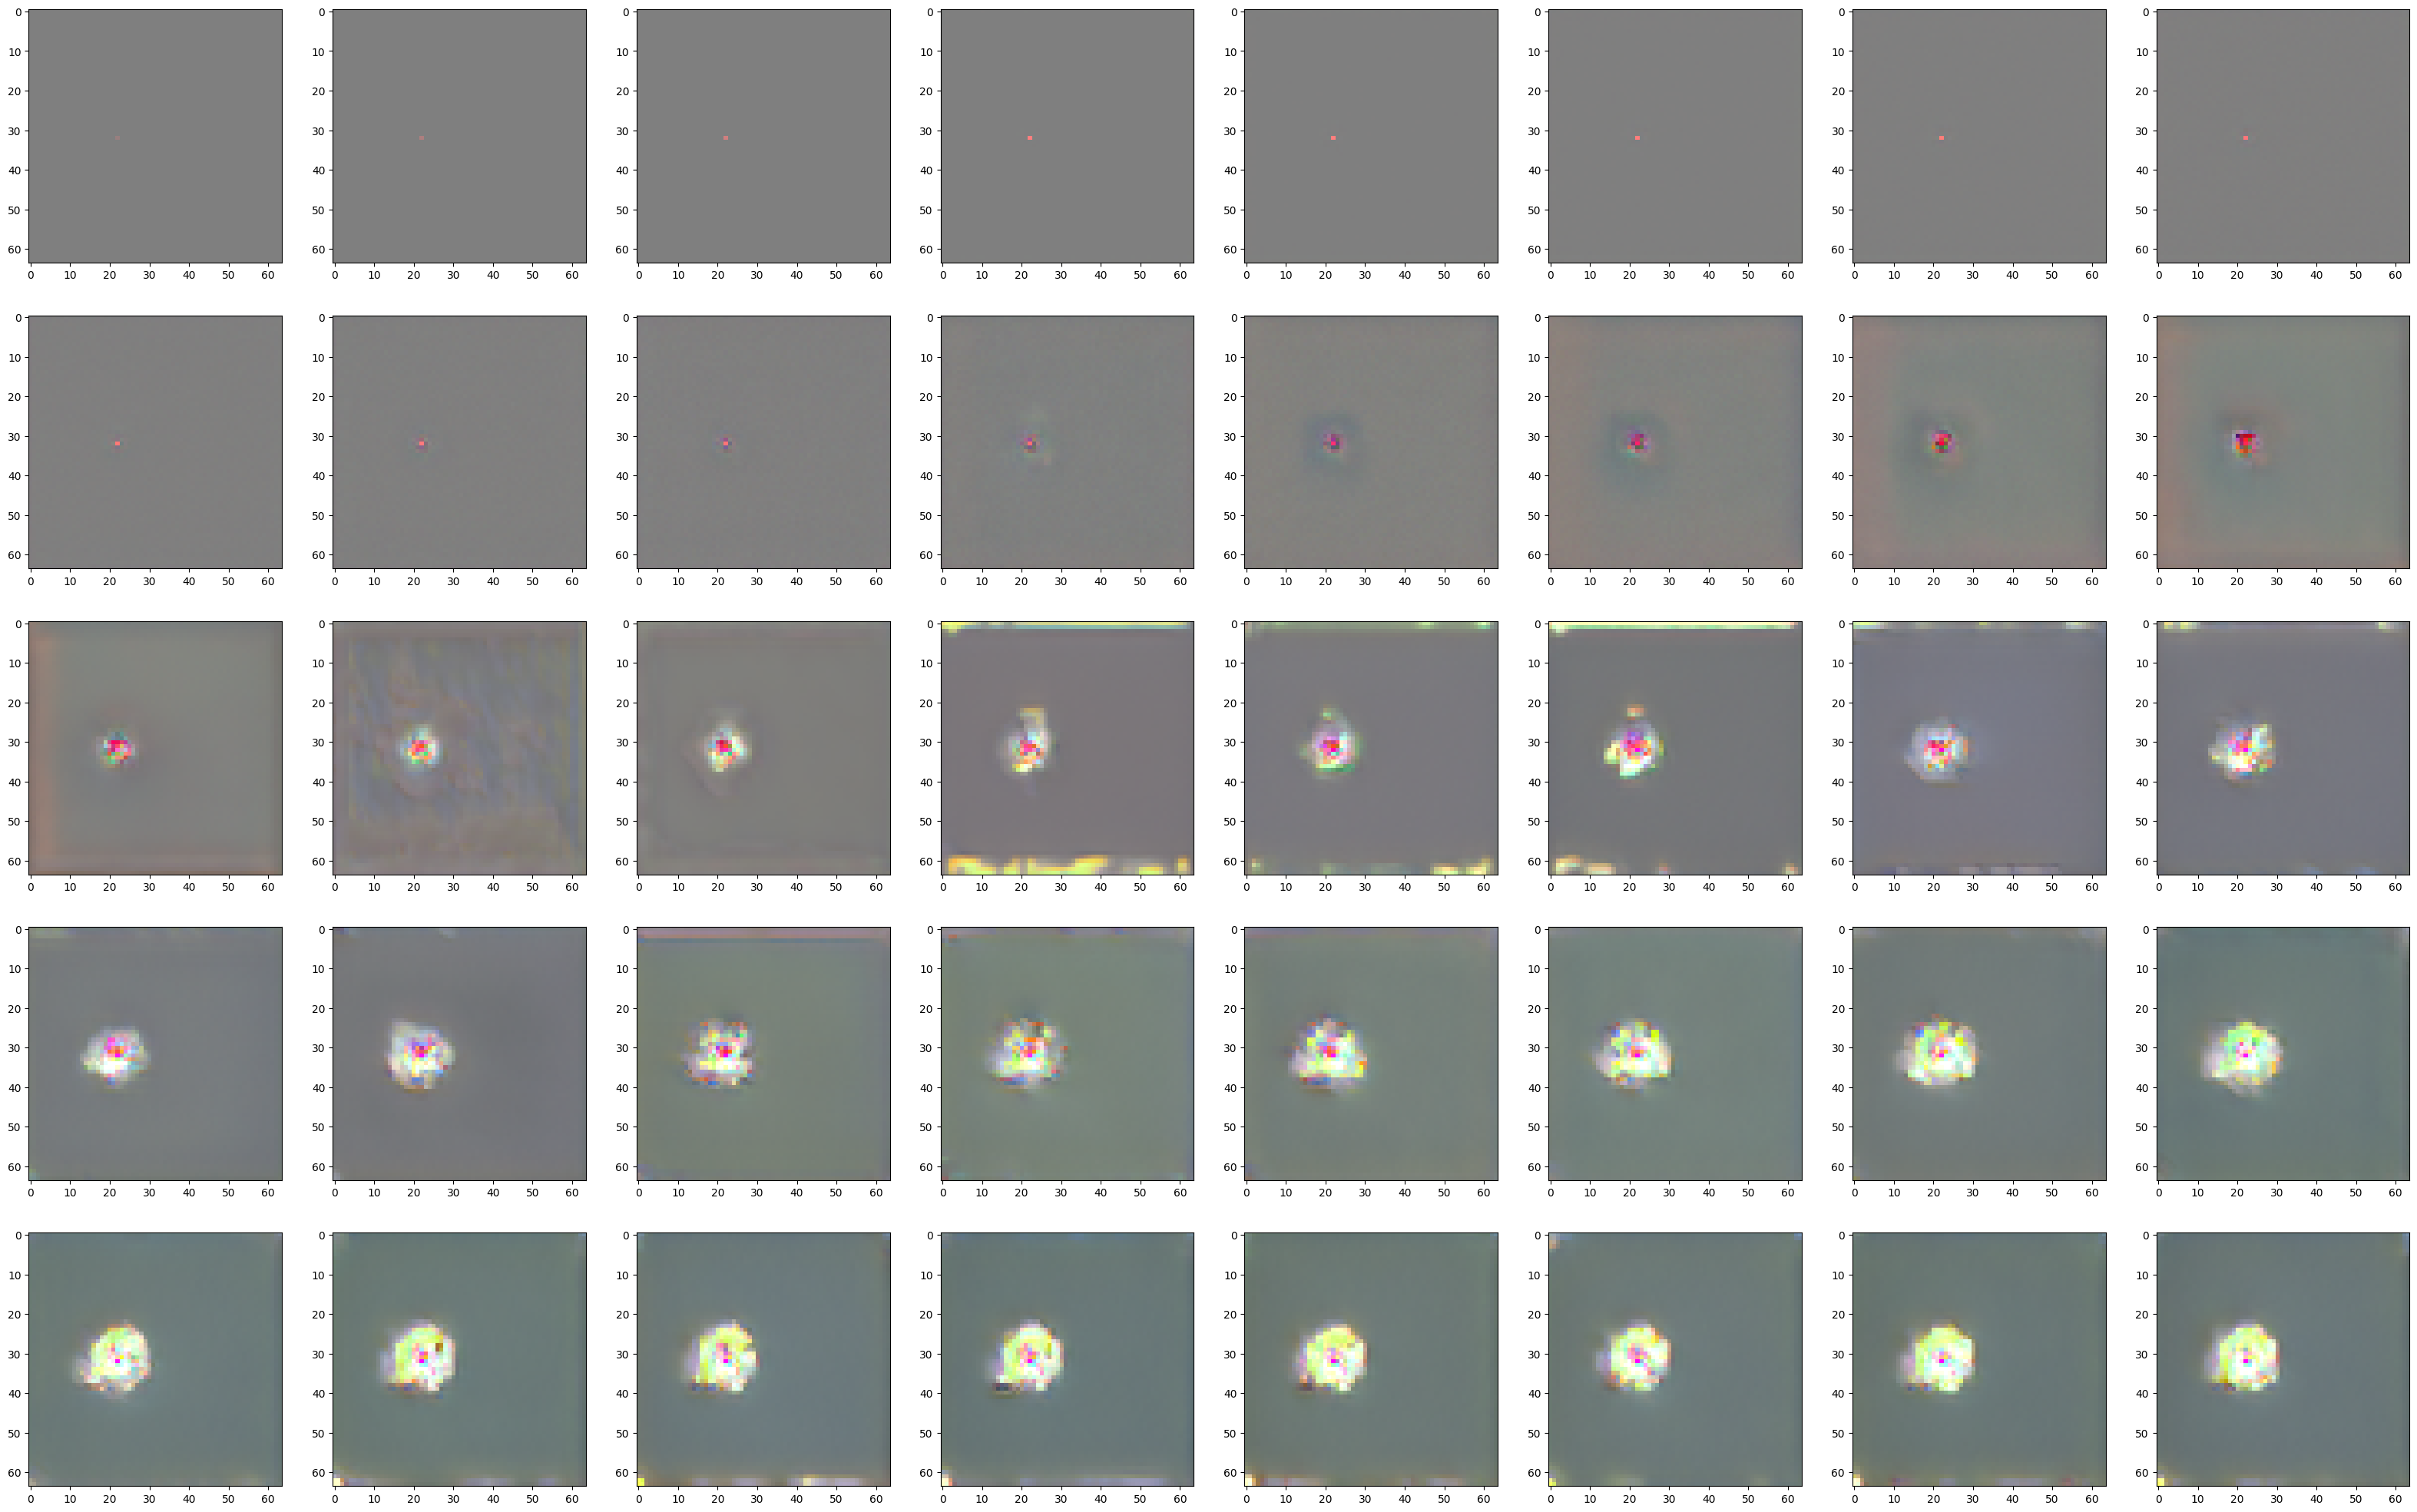

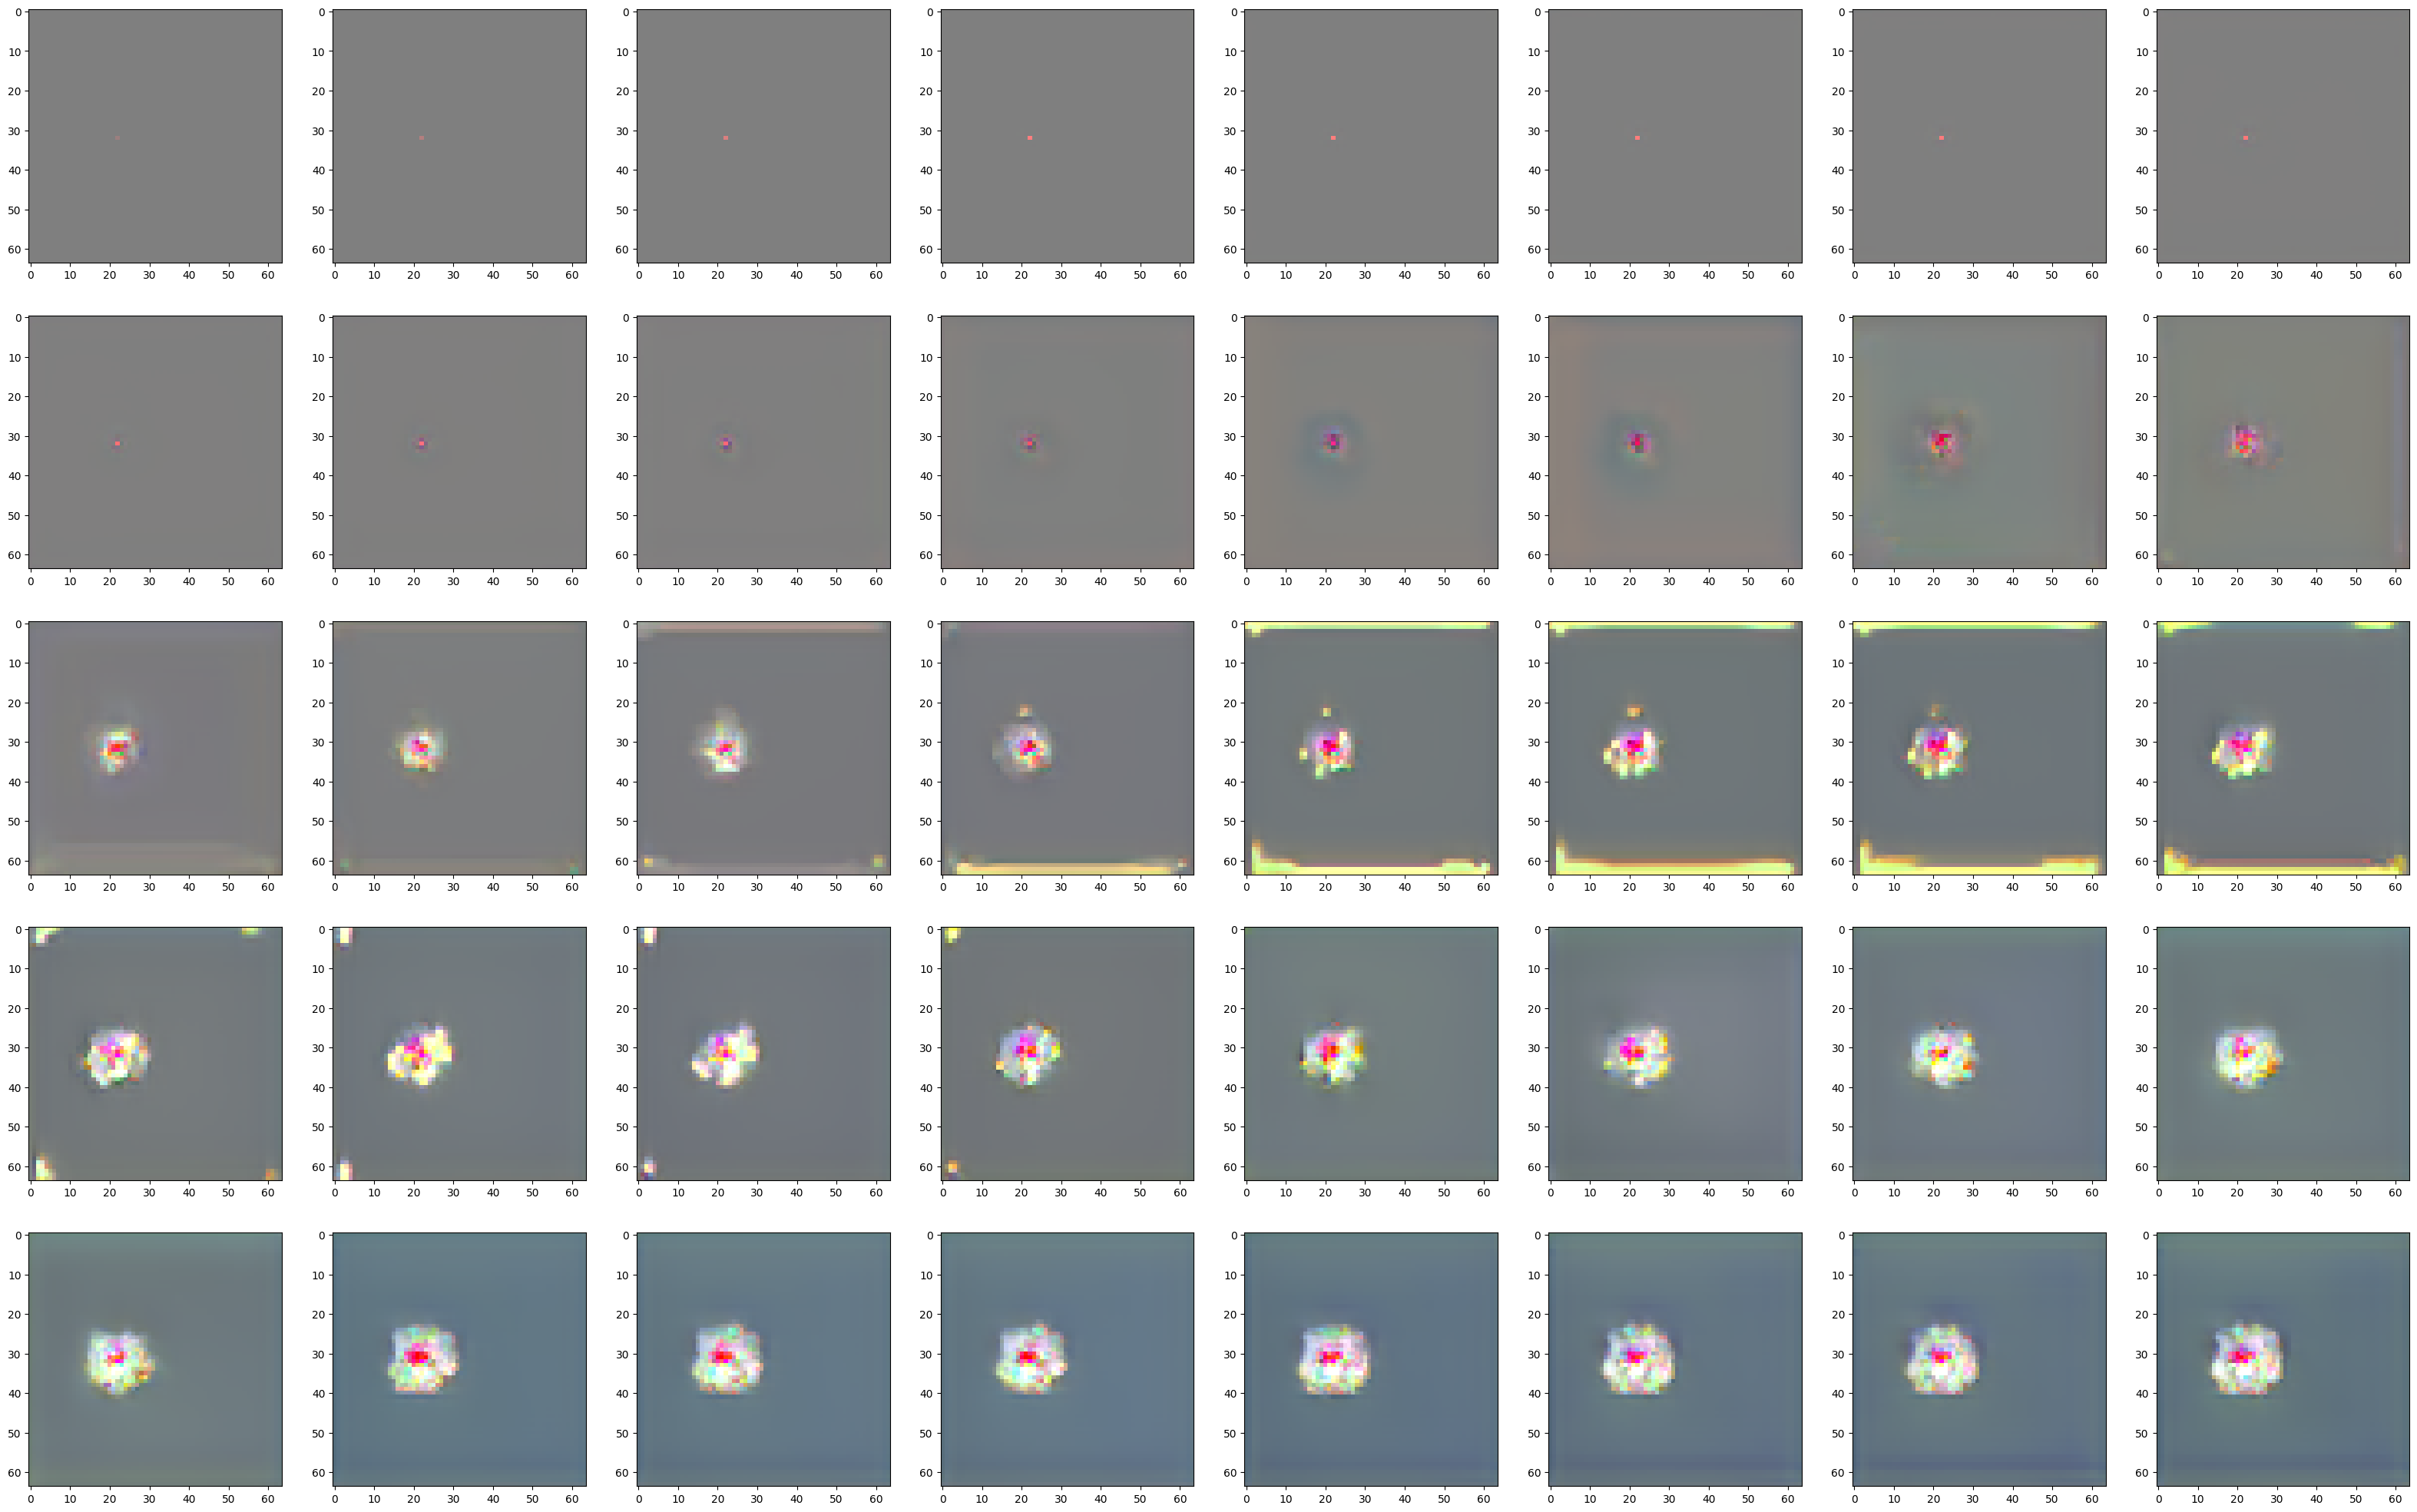

In [11]:
#fig, axs = plt.subplots(5,8, figsize=(40, 25))

#axs = axs.flatten()
i = 2070

n_alpha = 10

for alpha in torch.arange(n_alpha) / (n_alpha - 1):
    fig, axs = plt.subplots(5,8, figsize=(40, 25))
    axs = axs.flatten()
    for _, sigma in enumerate(list(reversed(pipe.scheduler.sigmas))[1:]):
        scale = torch.sqrt(torch.tensor(12288))  * sigma
    
        img = one_hot(i) * scale 
        
        z = sigma * torch.randn(img.shape).to(device).type(torch.float16)
        
        img_n = alpha * img + (1- alpha) *  z
        #img_n = img + sigma * torch.randn(img.shape).to(device).type(torch.float16)
        denoise_and_plot(img_n, sigma=sigma, ax=axs[_])

## Harmonic basis functions

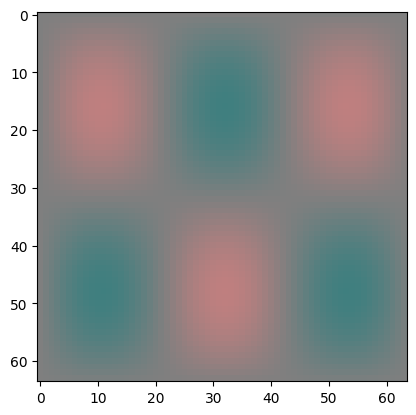

In [12]:
def harmonic_basis(x_dim=64, y_dim=64, lambda_x=1, lambda_y=1, amplitude=1, channel=0, n_channel=3, dtype=torch.float32, device="cuda"):
    x = torch.sin(lambda_x * torch.pi * torch.arange(64) / x_dim)
    y = torch.sin(lambda_y * torch.pi * torch.arange(64) / y_dim)

    grid = torch.outer(x,y).to(device).to(dtype)

    grid *= amplitude

    if channel is None:
        return grid

    channel_grid = torch.zeros((n_channel, y_dim, x_dim)).to(device).to(dtype)
    channel_grid[channel] = grid

    return channel_grid

plt.imshow(
    np.moveaxis((harmonic_basis(lambda_x=2, lambda_y=3, channel=0, amplitude=0.5) * 0.5 + 0.5).cpu().numpy(), 0, -1)
)


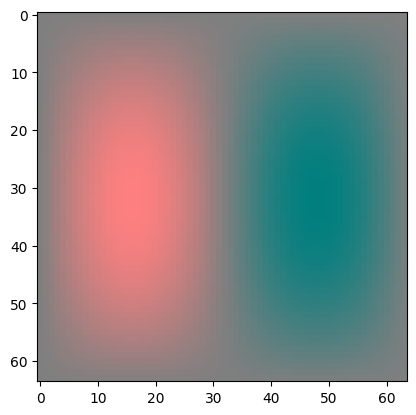

In [13]:
condition = harmonic_basis(lambda_x=1, lambda_y=2, channel=0, amplitude=1, dtype=torch.float16)[None, :]

image_clean = np.array(transforms.ToTensor()(image))

plt.imshow(
    np.moveaxis((condition.to(torch.float32)[0] * 0.5 + 0.5).cpu().numpy(), 0, -1)
)

#image_clean = 

/tmp/ipykernel_2931/215649153.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pipe.postprocess_image(torch.tensor(img_n, dtype=torch.float32).detach().cpu(), "np")[0]
/tmp/ipykernel_2931/2641483140.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)


<Axes: >

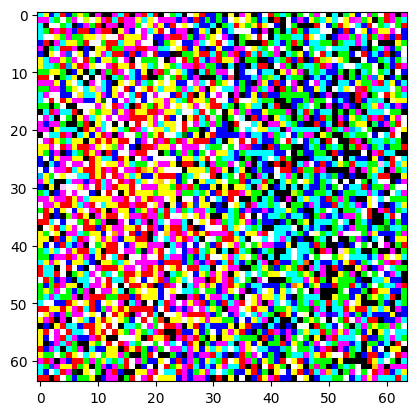

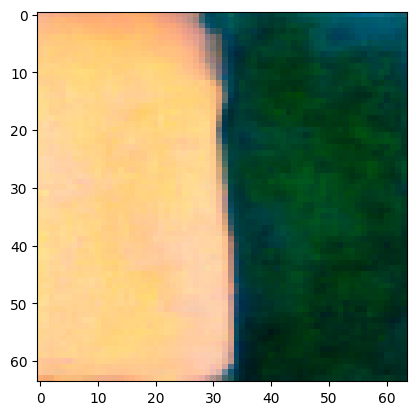

In [14]:

sigma = 80
z_score = 0.25

scale = torch.sqrt(torch.tensor(12288)) / torch.norm(condition)  * z_score * sigma

img = condition * scale 

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

img_n = img + z

# img_n = z

plt.imshow(
    pipe.postprocess_image(torch.tensor(img_n, dtype=torch.float32).detach().cpu(), "np")[0]
)

denoise_and_plot(img_n, sigma=sigma)

- do some sort of convex combination in sigma

## DFT of an image

/tmp/ipykernel_2931/2375494031.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = pipe.postprocess_image(torch.tensor(image, dtype=torch.float32).clone().detach().cpu(), "pt")[0]


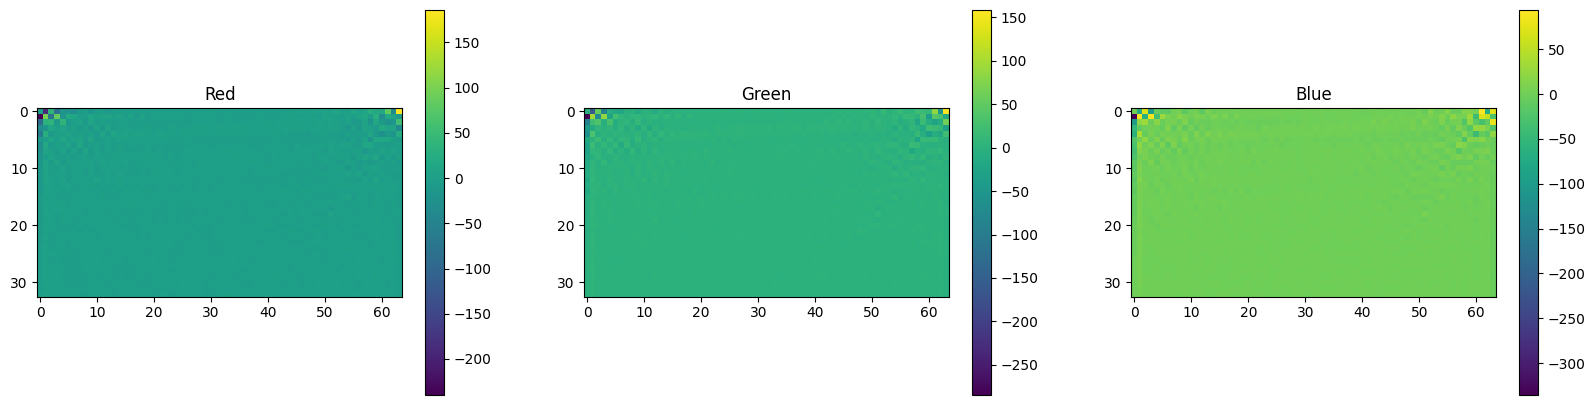

In [15]:
from torch.fft import rfft2

def plot_dft(image, is_processed=False):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs = axs.flatten()
    
    if not is_processed:
        image = pipe.postprocess_image(torch.tensor(image, dtype=torch.float32).clone().detach().cpu(), "pt")[0]
    
    #z_processed = pipe.postprocess_image(torch.tensor(z, dtype=torch.float32).clone().detach().cpu(), "pt")[0]
    
    
    #plt.imshow(
    #    np.moveaxis(z_processed.numpy(), 0, -1)
    #)
    
    img_ft = torch.view_as_real(rfft2(image))[:, :, :, 1]
    
    #z_ft = pipe.postprocess_image(torch.tensor(z_ft, dtype=torch.float32).clone().detach().cpu(), "pt")
    
    #print(z_ft.shape)
    cols = ["Red", "Green", "Blue"]
    #z_ft /= 1
    for i, ax in enumerate(axs):
    
        pcm = ax.imshow(
            np.moveaxis(img_ft[i].numpy(), 0, -1)
        )

        ax.set_title(cols[i])
    
        fig.colorbar(pcm, ax=ax)

plot_dft(img_dn)

/tmp/ipykernel_2931/2375494031.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = pipe.postprocess_image(torch.tensor(image, dtype=torch.float32).clone().detach().cpu(), "pt")[0]


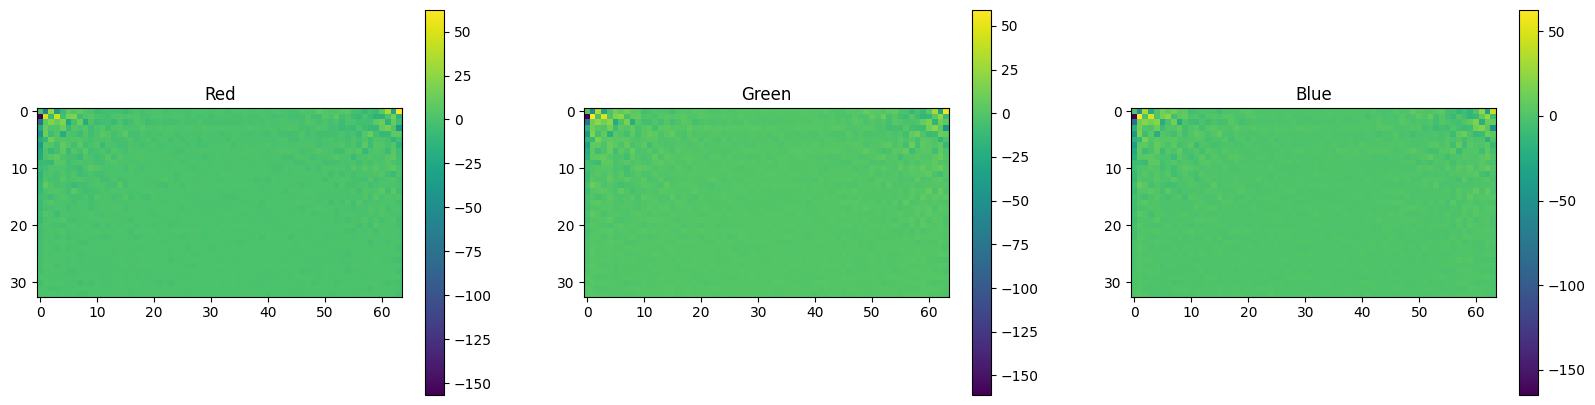

In [16]:
plot_dft(img_orig[None, :])